# IMPORTANT: Run all cells in prep_database.ipynb first to generate all the molecules and their features

In [1]:
from tqdm import tqdm, trange
from copy import deepcopy

import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import scipy as sp
import time
import sys
import importlib
import os
import hashlib
import subprocess
import gc
from datetime import datetime
from scipy import stats as st

from IPython import display
from IPython.display import clear_output
import copy
from copy import deepcopy

try:
    import cPickle as pickle
except:
    import pickle
    
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

experiment_folder="."
all_ligs_db_file=f"{experiment_folder}/all_ligands.pickle"

datafolder=f"{experiment_folder}/cached_reprs"

# sys.path.append(experiment_folder)

Bohr2Ang=0.529177249
RT=0.001985875*300 #kcal/mol


/tmp/ipykernel_367/1494992997.py:38: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# (Re)load Model and Dataset classes

In [163]:
if 'NNs' in sys.modules:
    importlib.reload(sys.modules['NNs'])
else:
    import NNs
from NNs import *

if 'computeDescriptors' in sys.modules:
    importlib.reload(sys.modules['computeDescriptors'])
else:
    import computeDescriptors
from computeDescriptors import *

# Load ligands and init Dataset

In [3]:
with open(all_ligs_db_file, 'rb') as f:
    ligs = pickle.load(f)
    
DB=CustomMolModularDataset(ligs)
print(f"{len(DB)} molecules with {DB[0][0].shape[0]} descriptors")

642 molecules with 6679 descriptors


## Remove constant and highly correlated features

In [4]:
allX=np.array([entry[0] for entry in DB])
print("Shape of all data:", allX.shape)

# exclude features that are always constant
keep_feature_indeces = np.where(np.logical_not(np.all(allX == allX[0,:], axis=0)))[0]
print(f"Variable (non-constant) features: {len(keep_feature_indeces)}")

#purge columns containing nans
# print(np.all(np.isfinite(allX[:,keep_feature_indeces]), axis=0).shape)
keep_feature_indeces = keep_feature_indeces[np.all(np.isfinite(allX[:,keep_feature_indeces]), axis=0)]
print(f"Finite (no nan or inf for any ligand) features: {len(keep_feature_indeces)}")


# correlation
cormat=np.corrcoef(allX[:,keep_feature_indeces].transpose())
cormat -= np.tril(cormat) # remove self correlation and lower triangular
cormat=np.abs(cormat) # absolute values

# find any columns with high correlations
cor_threshhold = 1.0
high_cor_pairs = np.where(cormat>=cor_threshhold)
to_remove = np.unique(high_cor_pairs[0]) # indeces to the keep_feature_indeces array
print(f"Highly correlated (>={cor_threshhold}) features to remove: {len(to_remove)}")

# WARNING/TODO: this removes features too agressively.
# If feature B is corelated to A and C to B, but not C to A
# this will remove both B and C.
# Ideally if we remove B, we should retain C, but that requires more recursion

# remove the correlated features
keep_mask = np.ones(len(keep_feature_indeces), np.bool_)
keep_mask[to_remove] = 0
keep_feature_indeces = keep_feature_indeces[keep_mask]

print(f"Keapt features: {len(keep_feature_indeces)}")

Shape of all data: (642, 6679)
Variable (non-constant) features: 5180
Finite (no nan or inf for any ligand) features: 5176
Highly correlated (>=1.0) features to remove: 464
Keapt features: 4712


## Reinitialize dataset object without the removed features

In [192]:
DB=CustomMolModularDataset(ligs, X_filter=keep_feature_indeces, normalize_x=False)
print(f"{len(DB)} molecules with {DB[0][0].shape[0]} descriptors remaining")

allYdata=(np.array([float(lig.GetProp('dG')) for lig in ligs]))
minY=np.min(allYdata)
maxY=np.max(allYdata)
print("Hydration energies between", minY, "and", maxY, "kcal/mol")

642 molecules with 4712 descriptors remaining
Hydration energies between -25.47 and 3.43 kcal/mol


## Settings for the NN and training procedure

In [195]:
normalize_x=True
shuffle_seed=1234567

#n_Epochs=2000
#hl_w=300
#hl_depth=2

n_Epochs=10000
hl_w=11
hl_depth=3

init_learning_rate=5e-3
learning_rate_decay=10000 #order of magnitude in this many epochs
weight_decay=1e-3

normalize_x=True
X_filter=keep_feature_indeces
impfilt=None

cap_output=1e5 # will cap network prediction at +/- this value. Prevents infinite validations loss due to overflow in torch.square within an MSE calculation

weighted=False
use_dropout=True
use_batchnorms=True
#shiftY=False # gets overwriten to True further down

redo=False
show_progress=False

batchsize=100
eval_batchsize=200
activation="relu"         # activation function to use
last_activation="sigmoid" # activation function override for second to last layer

eval_every=min(50, n_Epochs)
plot_every=min(5000, n_Epochs)
backup_models_every=10000

normalize_x=True          # normalize input features?
predict_all_ligs=True     # predict values for all molecules at the end?

save_folder="models/Perceptron"
max_cache_Mem_MB = 1024
train_summary_model = True # train models on all tarining data? If False will only do cross validation models.
dr_name="all_RDKit_Descr" # what to call the data representation


n_starting_ligs=int(np.floor(len(ligs)*0.8)) # num training ligands, will be split into cross validation blocks
XVal_blocks = 3 # num cross-validation blocks in training set

device = torch.device("cpu") #assume initial allocation on cpu


validation_db_file = "just not None" # flag for whether to calculate metrics on the validation set, None or False or "" -> No

## Prep Training

In [196]:
#shuffle ligand indeces
all_idxs_shuffled=np.arange(len(ligs))
np.random.seed(shuffle_seed)
np.random.shuffle(all_idxs_shuffled) # in place transform

#select training and validation(unknown) sets
np.random.shuffle(all_idxs_shuffled)
print("# training ligands:",n_starting_ligs, datetime.now(), flush=True)
known_idxs=all_idxs_shuffled[:n_starting_ligs]
unknown_idxs=all_idxs_shuffled[n_starting_ligs:]
n_val_ligs=len(unknown_idxs)
print("# validation ligands:",n_val_ligs, datetime.now(), flush=True)


if(X_filter is not None):
    if type(X_filter) is np.ndarray:
        if(X_filter.ndim!=1):
            raise ValueError("X_filter should a 1D array or a filename of a pickled 1D array.")
    elif(not os.path.exists(X_filter)):
        raise(Exception(f"No such file: {X_filter}"))
        
if(weighted):
    kde = sp.stats.gaussian_kde(allYdata)
    temp_Y=np.linspace(np.min(allYdata), np.max(allYdata), 20, endpoint=True)
    temp_kde=kde(temp_Y)
    C=1/np.mean(1/temp_kde)
    def get_weights(y):
        return(C/kde(y))
    weight_func=get_weights
else:
    weight_func=None

if(use_dropout):
    p_dropout=np.repeat(0.5, hl_depth+1)
else:
    p_dropout=np.repeat(0.0, hl_depth+1)

noise=0.0

train_clr="blue"
Xval_clr="purple"
unkn_clr="green"
summary_train_clr="darkred"
summary_unkn_clr="peru"


#generator for all data
full_dataset = CustomMolModularDataset(ligs, X_filter=keep_feature_indeces, normalize_x=normalize_x)

if(normalize_x):
    full_dataset.find_normalization_factors()
    full_dataset.build_internal_filtered_cache()
    print("Found normalization factors across all ligands", datetime.now(), flush=True)
if(predict_all_ligs):
    all_generator = torch.utils.data.DataLoader(full_dataset, shuffle=False, batch_size=eval_batchsize)
if(validation_db_file is not None):
    val_dataset=CustomMolModularDataset([ligs[idx] for idx in unknown_idxs], X_filter=X_filter, normalize_x=normalize_x)
    val_dataset.copy_normalization_factors(full_dataset)
    val_dataset.build_internal_filtered_cache()
    val_generator = torch.utils.data.DataLoader(val_dataset, shuffle=False, batch_size=eval_batchsize)
    
multi_model_record=None
global_models=None
global_summary_model=None

os.makedirs(save_folder, exist_ok=True)
save_plot=save_folder+f"/summary_ep_{n_Epochs}.png"
print("Will save models in:\n\t", save_folder)



class MultiTrainingRecord:
    def __init__(self):
        self.epoch=[]
        
        self.metrics=["loss", "RMSD", "Cor", "TP", "FP", "AUC"]
        self.datasubsets=["Train", "Train_err", "XVal", "unknown", "Val", "Val_err"]
        #self.datasubsets=["Train", "Train_err", "XVal", "unknown", "Val"]
        
        self.sm_datasubsets=["sm_Train", "sm_Val", "sm_Train_err", "sm_Val_err"]
        #self.sm_datasubsets=["sm_Train", "sm_Val", "sm_Train_err"]
        
        for m in self.metrics:
            for d in self.datasubsets:
                setattr(self, m+'_'+d, [])
                
            for d in self.sm_datasubsets:
                setattr(self, m+'_'+d, [])
                
        self.kendalltau_XVal=[]
        self.final_pred=None
        self.best_pred=None
        
        self.summary_model_final_pred=None
        self.summary_model_best_pred=None
        
#95 % confidence interval assuming gaussian error model
# confinterval= lambda a: st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))[0]-np.mean(a)
confinterval = lambda a: 2*np.std(a)

# training ligands: 513 2023-11-28 23:40:53.284369
# validation ligands: 129 2023-11-28 23:40:53.284926
Found normalization factors across all ligands 2023-11-28 23:40:53.510858
Will save models in:
	 models/Perceptron


## Are the validation set feature values representative of the full dataset?

(129, 4712)
True


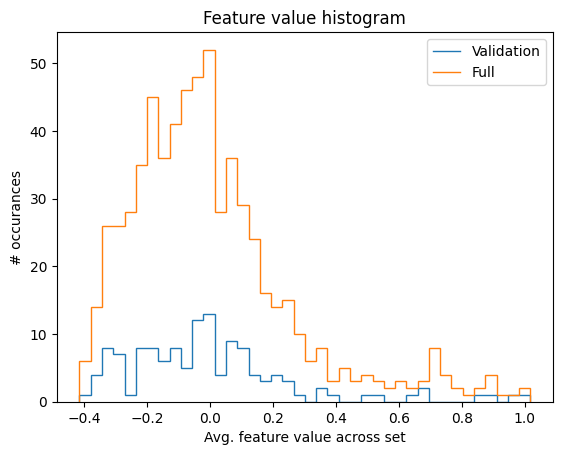

In [197]:
validation_X = np.array([v[0] for v in val_dataset])
validation_Y = np.array([v[1] for v in val_dataset]).flatten()
print(validation_X.shape)
print(np.all(np.isfinite(validation_X)))

counts, bins = np.histogram(np.mean(validation_X, axis=1), bins=40)
plt.stairs(counts, bins, label="Validation")

counts, bins = np.histogram(np.mean(np.array([v[0] for v in full_dataset]), axis=1), bins=40)
plt.stairs(counts, bins, label="Full")
plt.gca().set(xlabel='Avg. feature value across set', ylabel='# occurances', title="Feature value histogram")
plt.legend()
plt.show()

## Normalize Y output
So it does not saturate tails of a sigmoid or tanh activation function.<br>
Do this based on only the traing data (known_idxs), so models remain in the dark about validation data (unknown_idxs).<br>
Should be unnecessaruy now that we use BatchNorm.

mean:-3.8796296296296298	stdev:3.8789095425188913


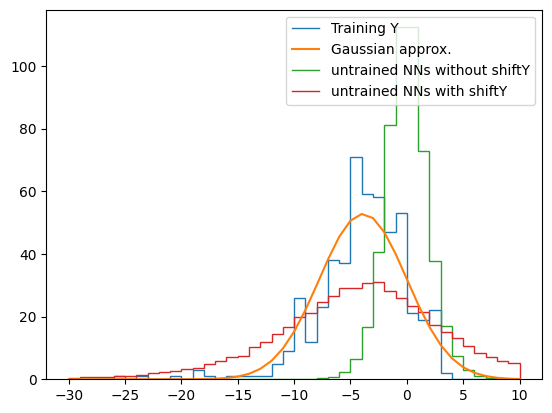

In [198]:
# histogram Y
trainingY=allYdata[known_idxs]
counts, bins = np.histogram(trainingY, bins=40, range=(-30,10))
plt.stairs(counts, bins, label="Training Y")

mean = np.mean(trainingY)
std = np.std(trainingY)
G = np.exp(-np.square(bins-mean)/(2*np.square(std))) / (np.sqrt(2*np.pi)*std) * len(trainingY)
plt.plot(bins,G, label="Gaussian approx.")

print(f"mean:{mean}\tstdev:{std}")



# test histogram of output of an untrained NN without shiftY

Train_set = CustomMolModularDataset([ligs[idx] for idx in known_idxs],
                                    normalize_x=normalize_x, X_filter=X_filter,
                                    internal_cache_maxMem_MB=max_cache_Mem_MB)
Train_set.copy_normalization_factors(full_dataset)
Train_set.build_internal_filtered_cache()
Train_gen=torch.utils.data.DataLoader(Train_set, shuffle=False,  batch_size=len(known_idxs))
n_features = Train_set[0][0].shape[-1]



shiftY = False

untrained_outs=[]
for i in range(100):
    model = Net(inp_width=n_features, hl_w=hl_w, nhl=hl_depth, activation=activation, last_activation=last_activation,
                    learning_rate=init_learning_rate, lr_decay=learning_rate_decay,
                    high_binder_cutoff=0, # used for calculation of TPR/FPR
                    weight_decay=weight_decay, cap_output=cap_output,
                    weights_distrib_func=weight_func, drop_p=p_dropout, use_batchnorms=use_batchnorms,
                    noise=noise, shiftY=shiftY).to(device)
    untrained_outs.append(model.eval()(next(iter(Train_gen))[0]).detach().cpu().numpy().flatten())
untrained_outs=np.array(untrained_outs).flatten()

counts, bins = np.histogram(untrained_outs, bins=40, range=(-30,10))
counts = counts/100
plt.stairs(counts, bins, label="untrained NNs without shiftY")



# set shiftY to these values so NN shifts and scales final output to match this range
shiftY = (std, mean)

untrained_outs=[]
for i in range(100):
    model = Net(inp_width=n_features, hl_w=hl_w, nhl=hl_depth, activation=activation, last_activation=last_activation,
                    learning_rate=init_learning_rate, lr_decay=learning_rate_decay,
                    high_binder_cutoff=0, # used for calculation of TPR/FPR
                    weight_decay=weight_decay, cap_output=cap_output,
                    weights_distrib_func=weight_func, drop_p=p_dropout, use_batchnorms=use_batchnorms,
                    noise=noise, shiftY=shiftY).to(device)
    untrained_outs.append(model.eval()(next(iter(Train_gen))[0]).detach().cpu().numpy().flatten())
untrained_outs=np.array(untrained_outs).flatten()

counts, bins = np.histogram(untrained_outs, bins=40, range=(-30,10))
counts = counts/100
plt.stairs(counts, bins, label="untrained NNs with shiftY")



plt.legend()
del model, Train_set, Train_gen

# Train

Start setting up models 2023-11-28 23:41:01.718176
There are 4712 features 2023-11-28 23:41:01.718730
Finished setup for summary model 2 2023-11-28 23:41:01.734306
Training for 10000 epochs 2023-11-28 23:41:01.734482


Epoch: 100%|█████████████████████████████████████████████████████████████████████████████████████████▉| 9999/10000 [04:29<00:00, 39.41it/s]

Epoch 9999. Backing up models.


Epoch: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [04:29<00:00, 37.06it/s]


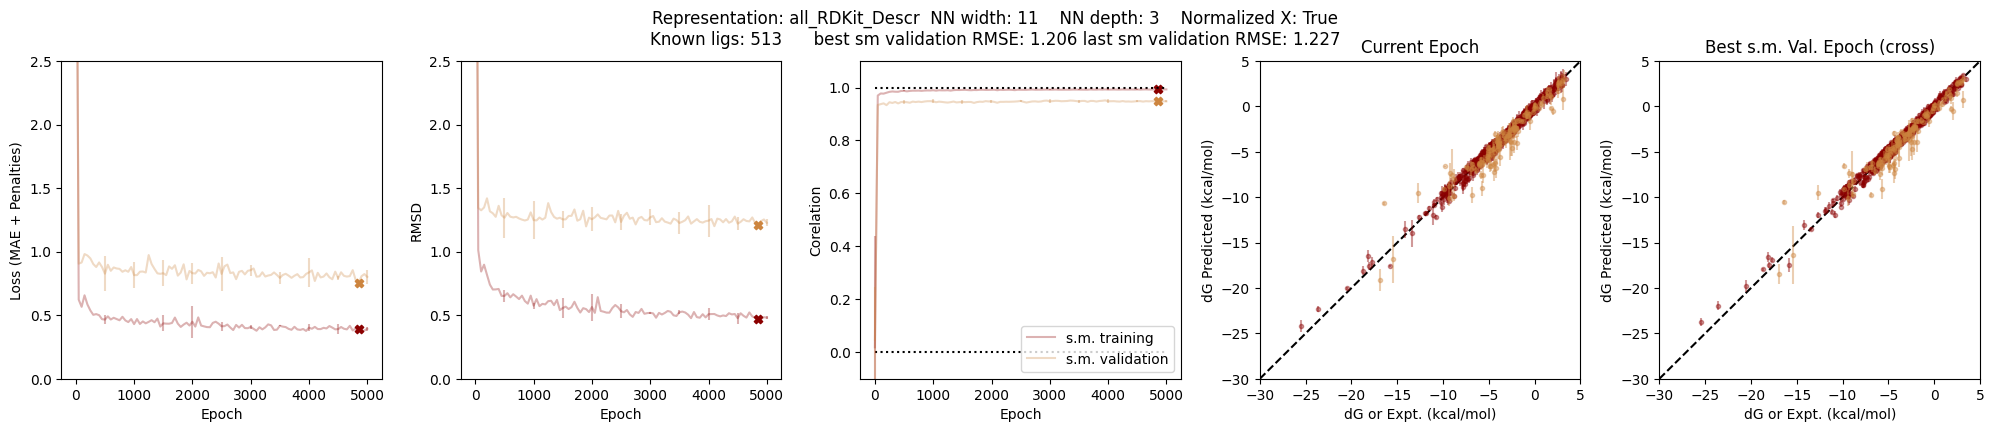

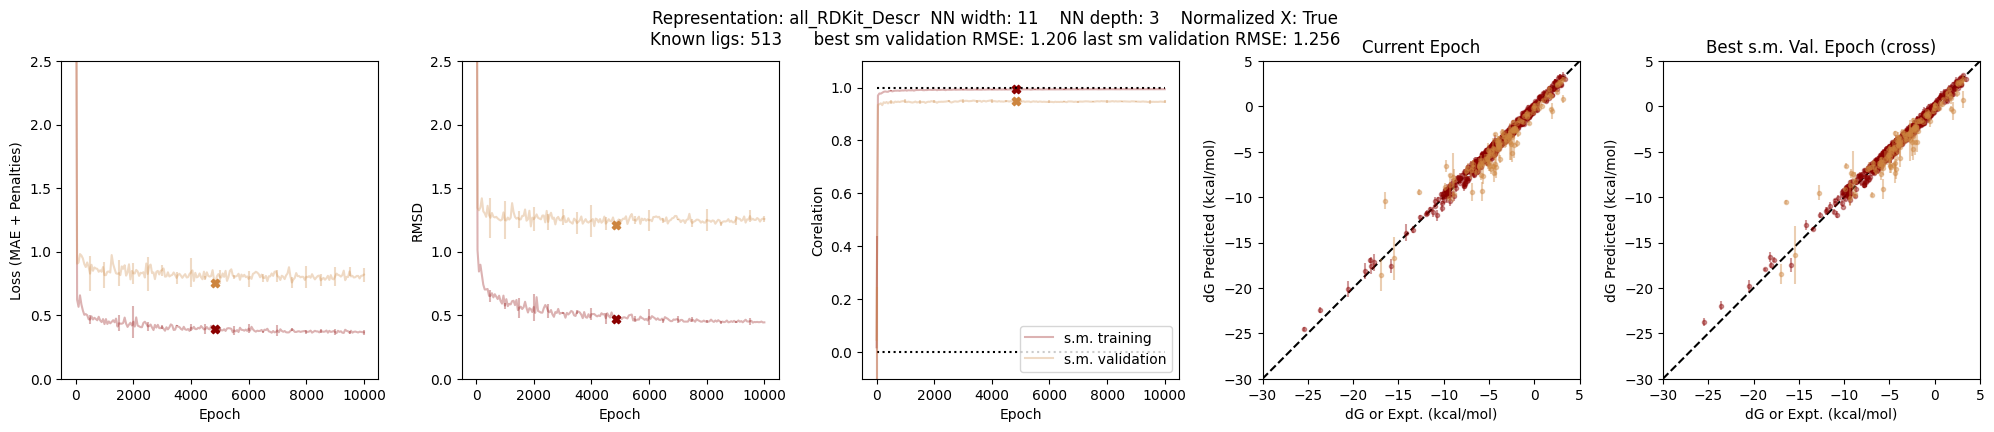

In [199]:
#################
# do the training
#################
print("Start setting up models", datetime.now(), flush=True)

if(predict_all_ligs):
    n_features = full_dataset[0][0].shape[-1]
else:
    #no point normalising or building internal cache for this one, we just want to know # of features it spits out
    tempDS = CustomMolModularDataset([ligs[0]],
                                 normalize_x=False,
                                 X_filter=X_filter,
                                 internal_cache_maxMem_MB=0)
    n_features = tempDS[0][0].shape[-1]
    del tempDS
    _=gc.collect()
known_Y=allYdata[known_idxs]
print("There are", n_features, "features", datetime.now(), flush=True)

models=[]
model_Train_idxs=[]
model_XVal_idxs=[]
split_gen=data_split(known_idxs)
# for drop in range(XVal_blocks):

#     #create model
#     model = Net(inp_width=n_features, hl_w=hl_w, nhl=hl_depth, activation=activation, last_activation=last_activation,
#                 learning_rate=init_learning_rate, lr_decay=learning_rate_decay,
#                 high_binder_cutoff=0, # used for calculation of TPR/FPR
#                 weight_decay=weight_decay, cap_output=cap_output,
#                 weights_distrib_func=weight_func, drop_p=p_dropout, use_batchnorms=use_batchnorms,
#                 noise=noise, shiftY=shiftY).to(device)

#     #create training, cross validation, and test data
#     Train_indeces, XVal_indeces = next(split_gen)

#     #save as indexes within known_idxs array
#     model_Train_idxs.append(Train_indeces)
#     model_XVal_idxs.append(XVal_indeces)

#     Train_indeces = known_idxs[Train_indeces] #convert indexing into the ligs array
#     XVal_indeces  = known_idxs[XVal_indeces]  #convert indexing into the ligs array

#     Train_set = CustomMolModularDataset([ligs[idx] for idx in Train_indeces],
#                                         normalize_x=normalize_x, X_filter=X_filter,
#                                         internal_cache_maxMem_MB=max_cache_Mem_MB)
#     XVal_set  = CustomMolModularDataset([ligs[idx] for idx in XVal_indeces ],
#                                         normalize_x=normalize_x, X_filter=X_filter,
#                                         internal_cache_maxMem_MB=max_cache_Mem_MB)
#     Train_set.copy_normalization_factors(full_dataset)
#     XVal_set.copy_normalization_factors(full_dataset)

#     #build_internal_filtered_cache
#     Train_set.build_internal_filtered_cache()
#     XVal_set.build_internal_filtered_cache()

#     #create training, cross validation, and test datagens
#     model.training_generator            = torch.utils.data.DataLoader(Train_set, shuffle=True,  batch_size=batchsize)
#     model.training_generator_no_shuffle = torch.utils.data.DataLoader(Train_set, shuffle=False, batch_size=eval_batchsize)
#     model.crossvalidation_generator     = torch.utils.data.DataLoader(XVal_set,  shuffle=False, batch_size=eval_batchsize)

#     #add tracking of validation ligands
#     if(validation_db_file is not None):
#         model.test_generator            = val_generator

#     del Train_set, XVal_set

#     models.append(model)
#     print("Finished setup for model", drop, datetime.now())

summary_models=[]
Train_set = CustomMolModularDataset([ligs[idx] for idx in known_idxs],
                                    normalize_x=normalize_x, X_filter=X_filter,
                                    internal_cache_maxMem_MB=max_cache_Mem_MB)
Train_set.copy_normalization_factors(full_dataset)
Train_set.build_internal_filtered_cache()
sm_gen_shuffle=torch.utils.data.DataLoader(Train_set, shuffle=True,  batch_size=batchsize)
sm_gen_no_shuffle=torch.utils.data.DataLoader(Train_set, shuffle=False,  batch_size=batchsize)

if(train_summary_model):
    for drop in range(XVal_blocks):
        sm = Net(inp_width=n_features, hl_w=hl_w, nhl=hl_depth, activation=activation, last_activation=last_activation,
                learning_rate=init_learning_rate, lr_decay=learning_rate_decay,
                high_binder_cutoff=0, weight_decay=weight_decay, cap_output=cap_output,
                weights_distrib_func=weight_func, drop_p=p_dropout, use_batchnorms=use_batchnorms,
                noise=noise, shiftY=shiftY).to(device)

        sm.training_generator            = sm_gen_shuffle
        sm.training_generator_no_shuffle = sm_gen_no_shuffle

        #add tracking of validation ligands
        if(validation_db_file is not None):
            sm.test_generator            = val_generator

        summary_models.append(sm)

    print("Finished setup for summary model", drop, datetime.now())
del Train_set

multi_model_record = MultiTrainingRecord()
if (validation_db_file is None):
    print("There is no validation dataset provided. Disabling validation metrics.")
    multi_model_record.datasubsets=["Train", "Train_err", "XVal"]
    multi_model_record.sm_datasubsets=["sm_Train", "sm_Train_err"]

print("Training for", n_Epochs, "epochs", datetime.now(), flush=True)
pbar = trange(0, n_Epochs, desc="Epoch")
for ep in pbar:    
    #train K_fold models
    for drop in range(XVal_blocks):
#         models[drop].train_epoch(eval_every=eval_every)

        if(train_summary_model):
            summary_models[drop].train_epoch(eval_every=eval_every)

    if ep%eval_every == eval_every-1 or ep == 0:            
        all_Y_known=torch.zeros((len(known_idxs), 1), dtype=torch.float, device=device)
        multi_P_XVal=torch.zeros((len(known_idxs), 1), dtype=torch.float, device=device)
#             multi_P_eval=torch.zeros((len(evaluation_half), 1, XVal_blocks), dtype=torch.float, device=device)
#         for drop in range(XVal_blocks):
#             test_ndxs=model_XVal_idxs[drop]
#             P_XVal, Y_XVal = models[drop].get_predictions_from_batches(models[drop].crossvalidation_generator, with_np=False)
#             multi_P_XVal[test_ndxs,:]= P_XVal
#             all_Y_known[test_ndxs,:] = Y_XVal

#         np_all_Y_known=all_Y_known.detach().cpu().numpy()[:,0]
#         np_multi_P_XVal=multi_P_XVal.detach().cpu().numpy()[:,0]

#         XVal_loss=models[0].loss_fn(all_Y_known, multi_P_XVal).detach().cpu().tolist()
#         XVal_RMSE=torch.sqrt(models[0].loss_mse(all_Y_known, multi_P_XVal)).detach().cpu().numpy()
#         XVal_Cor=np.corrcoef(np_all_Y_known.flatten(), np_multi_P_XVal.flatten())[0,1]
#         XVal_KT=sp.stats.kendalltau(np_all_Y_known.flatten(), np_multi_P_XVal.flatten())[0]


#         #true and false positive rates + AUC
#         with warnings.catch_warnings():
#             warnings.simplefilter("ignore")
#             #XVal_FP, XVal_TP, XVal_AUC = get_FPR_TPR_AUC(np_all_Y_known, np_multi_P_XVal, high_binder_cutoff)
#             XVal_FP, XVal_TP = get_FPR_and_TPR(np_all_Y_known, np_multi_P_XVal, high_binder_cutoff)
#             XVal_AUC = get_fixed_ROC_AUC(np_all_Y_known, np_multi_P_XVal, P_err=None, cut=high_binder_cutoff)

#         #save state at best XVal loss
#         if(ep>0 and XVal_loss < np.min(multi_model_record.loss_XVal)):
#             for m in models:
#                 m.cache_state()

        #95 % confidence interval assuming gaussian error model
        #confinterval= lambda a: st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))[0]-np.mean(a)

        multi_model_record.epoch.append(ep)
#         multi_model_record.loss_XVal.append(XVal_loss)
#         multi_model_record.RMSD_XVal.append(XVal_RMSE)
#         multi_model_record.Cor_XVal.append(XVal_Cor)
#         multi_model_record.kendalltau_XVal.append(XVal_KT)

#         multi_model_record.TP_XVal.append(XVal_TP)
#         multi_model_record.FP_XVal.append(XVal_FP)
#         multi_model_record.AUC_XVal.append(XVal_AUC)

#         #all the other metrics taken from individual models
#         func_mean = lambda n : np.mean([getattr(m.record, n)[-1] for m in models])
#         func_err = lambda n : confinterval([getattr(m.record, n)[-1] for m in models])
#         for d in multi_model_record.datasubsets:
#             srcd=d
#             f=func_mean
#             if(d=="XVal" or "summary_model" in d or d=="unknown"):
#                 continue; #these are set manually
#             if((d=="Val" or d=="Val_err") and validation_db_file is None):
#                 continue; # can't record validation metrics if there is no validation dataset
#             if ("_err" in d):
#                 srcd=d[:-4]
#                 f=func_err

#             for metric in multi_model_record.metrics:
#                 atrname=metric+'_'+d
#                 srcname=metric+'_'+srcd
#                 try:
#                     getattr(multi_model_record, atrname).append(f(srcname))
#                 except Exception as e:
#                     print(f"d={d}\t atrname={atrname}\t srcname={srcname}", flush=True)
#                     raise(e);

        if(train_summary_model):
            sm_func_mean = lambda n : np.mean([getattr(sm.record, n)[-1] for sm in summary_models])
            sm_func_err = lambda n : confinterval([getattr(sm.record, n)[-1] for sm in summary_models])
            for d in multi_model_record.sm_datasubsets:
                for metric in multi_model_record.metrics:
                    srcd=d[3:]
                    f=sm_func_mean
                    if ("_err" in d):
                        srcd=d[3:-4]
                        f=sm_func_err

                    atrname=metric+'_'+d
                    srcname=metric+'_'+srcd
                    getattr(multi_model_record, atrname).append(f(srcname))


        #save state at best Val loss for summary_model
        if(train_summary_model):
            if(ep>0 and multi_model_record.loss_sm_Val[-1] < np.min(multi_model_record.loss_sm_Val[:-1])):
                for sm in summary_models:
                    sm.cache_state()



        if(show_progress):
#             if(validation_db_file is None):
#                 print(f"\tEpoch: {ep}\t train_loss={multi_model_record.loss_Train[-1]}\t XVal_RMSE={XVal_RMSE}", end="")
#             else:
#                 print(f"\tEpoch: {ep}\t train_loss={multi_model_record.loss_Train[-1]:.4f}+-{multi_model_record.loss_Train_err[-1]:.4f}\t XVal_RMSE={XVal_RMSE:.4f}\t Val_RMSE={multi_model_record.RMSD_Val[-1]:.4f}+-{multi_model_record.RMSD_Val_err[-1]:.4f}", end="")

            if(train_summary_model):
                if(validation_db_file is None):
                    print(f"\t sm_train_loss={multi_model_record.loss_sm_Train[-1]:.4}", end="")
                else:
                    print(f"\t sm_train_loss={multi_model_record.loss_sm_Train[-1]:.4}\t sm_Val_RMSE={multi_model_record.RMSD_sm_Val[-1]:.4f}", end="")

            print("", flush=True)


#     # check for nans and restart training if detected
#     if(not np.isfinite(multi_model_record.loss_Train[-1]) or not np.isfinite(XVal_RMSE)):
#         print([m.record.loss_XVal for m in models])
#         print([m.record.loss_Val for m in models])
#         raise(RuntimeError("Nan in metrics"))                    

    #plot all models at once
    if ep%plot_every == plot_every-1 or ep==n_Epochs-1:

        fig=plt.figure(figsize=(20,8))
        sp_grid = gridspec.GridSpec(2, 5)

        ax = plt.subplot(sp_grid[0,0])
        plt.ylim(0, 2.5)
        rec = multi_model_record
#         bi=np.argmin(rec.loss_XVal)
        if(validation_db_file is not None):
            sm_bi=np.argmin(rec.loss_sm_Val)

#         ax.errorbar(rec.epoch[::10], rec.loss_Train[::10], yerr=rec.loss_Train_err[::10], color=train_clr, alpha=0.3, linestyle="none")
#         ax.plot(rec.epoch, rec.loss_Train, alpha=0.3, label="training", color=train_clr)
#         ax.plot(rec.epoch, rec.loss_XVal, alpha=0.3, label="cross validation", color=Xval_clr)
#         ax.scatter(rec.epoch[bi], rec.loss_Train[bi], color=train_clr, marker="*")
#         ax.scatter(rec.epoch[bi], rec.loss_XVal[bi], color=Xval_clr, marker="*")
#         eprange=[0,ep]
#         MAE_best=[rec.loss_XVal[bi],rec.loss_XVal[bi]]
#         MAE_last=[rec.loss_XVal[-1],rec.loss_XVal[-1]]
#         ax.plot(eprange, MAE_best, '--k', zorder=0, alpha=0.3, label=None)
#         ax.plot(eprange, MAE_last, '--k', zorder=0, alpha=0.3, label=None)
#         if(validation_db_file is not None):
#             ax.errorbar(rec.epoch[::10], rec.loss_Val[::10], yerr=rec.loss_Val_err[::10], color=unkn_clr, alpha=0.3, linestyle="none")
#             ax.plot(rec.epoch, rec.loss_Val, alpha=0.3, label="validation", color=unkn_clr)
#             ax.scatter(rec.epoch[bi], rec.loss_Val[bi], color=unkn_clr, marker="*")
        if(train_summary_model):
            ax.errorbar(rec.epoch[::10], rec.loss_sm_Train[::10], yerr=rec.loss_sm_Train_err[::10], color=summary_train_clr, alpha=0.3, linestyle="none")
            ax.plot(rec.epoch, rec.loss_sm_Train, alpha=0.3, label="s.m. training", color=summary_train_clr)
            ax.scatter(rec.epoch[sm_bi], rec.loss_sm_Train[sm_bi], color=summary_train_clr, marker="X")
            if(validation_db_file is not None):
                ax.errorbar(rec.epoch[::10], rec.loss_sm_Val[::10], yerr=rec.loss_sm_Val_err[::10], color=summary_unkn_clr, alpha=0.3, linestyle="none")
                ax.plot(rec.epoch, rec.loss_sm_Val, alpha=0.3, label="s.m. validation", color=summary_unkn_clr)
                ax.scatter(rec.epoch[sm_bi], rec.loss_sm_Val[sm_bi], color=summary_unkn_clr, marker="X")


        ax.set(xlabel='Epoch', ylabel='Loss (MAE + Penalties)')

        ax = plt.subplot(sp_grid[0,1])
        plt.ylim(0, 2.5)
#         ax.errorbar(rec.epoch[::10], rec.RMSD_Train[::10], yerr=rec.RMSD_Train_err[::10], color=train_clr, alpha=0.3, linestyle="none")
#         ax.plot(rec.epoch, rec.RMSD_Train, alpha=0.3, label="training", color=train_clr)
#         ax.plot(rec.epoch, rec.RMSD_XVal, alpha=0.3, label="cross validation", color=Xval_clr)
#         ax.scatter(rec.epoch[bi], rec.RMSD_Train[bi], color=train_clr, marker="*")
#         ax.scatter(rec.epoch[bi], rec.RMSD_XVal[bi], color=Xval_clr, marker="*")
        ax.set(xlabel='Epoch', ylabel='RMSD')
#         if(validation_db_file is not None):
#             ax.errorbar(rec.epoch[::10], rec.RMSD_Val[::10], yerr=rec.RMSD_Val_err[::10], color=unkn_clr, alpha=0.3, linestyle="none")
#             ax.plot(rec.epoch, rec.RMSD_Val, alpha=0.3, label="validation", color=unkn_clr)
#             ax.scatter(rec.epoch[bi], rec.RMSD_Val[bi], color=unkn_clr, marker="*")
        if(train_summary_model):
            ax.errorbar(rec.epoch[::10], rec.RMSD_sm_Train[::10], yerr=rec.RMSD_sm_Train_err[::10], color=summary_train_clr, alpha=0.3, linestyle="none")
            ax.plot(rec.epoch, rec.RMSD_sm_Train, alpha=0.3, label="s.m. training", color=summary_train_clr)
            ax.scatter(rec.epoch[sm_bi], rec.RMSD_sm_Train[sm_bi], color=summary_train_clr, marker="X")
            if(validation_db_file is not None):
                ax.errorbar(rec.epoch[::10], rec.RMSD_sm_Val[::10], yerr=rec.RMSD_sm_Val_err[::10], color=summary_unkn_clr, alpha=0.3, linestyle="none")
                ax.plot(rec.epoch, rec.RMSD_sm_Val, alpha=0.3, label="s.m. validation", color=summary_unkn_clr)
                ax.scatter(rec.epoch[sm_bi], rec.RMSD_sm_Val[sm_bi], color=summary_unkn_clr, marker="X")

        ax = plt.subplot(sp_grid[0,2])
        plt.ylim(-0.1, 1.1)
        plt.hlines(0, np.min(rec.epoch), np.max(rec.epoch), colors='k', linestyles='dotted', label='')
        plt.hlines(1, np.min(rec.epoch), np.max(rec.epoch), colors='k', linestyles='dotted', label='')
#         ax.errorbar(rec.epoch[::10], rec.Cor_Train[::10], yerr=rec.Cor_Train_err[::10], color=train_clr, alpha=0.3, linestyle="none")
#         ax.plot(rec.epoch, rec.Cor_Train, alpha=0.3, label="training", color=train_clr)
#         ax.plot(rec.epoch, rec.Cor_XVal, alpha=0.3, label="cross validation", color=Xval_clr)
#         ax.scatter(rec.epoch[bi], rec.Cor_Train[bi], color=train_clr, marker="*")
#         ax.scatter(rec.epoch[bi], rec.Cor_XVal[bi], color=Xval_clr, marker="*")
        ax.set(xlabel='Epoch', ylabel='Corelation')
#         if(validation_db_file is not None):
#             ax.errorbar(rec.epoch[::10], rec.Cor_Val[::10], yerr=rec.Cor_Val_err[::10], color=unkn_clr, alpha=0.3, linestyle="none")
#             ax.plot(rec.epoch, rec.Cor_Val, alpha=0.3, label="validation", color=unkn_clr)
#             ax.scatter(rec.epoch[bi], rec.Cor_Val[bi], color=unkn_clr, marker="*")
        if(train_summary_model):
            ax.errorbar(rec.epoch[::10], rec.Cor_sm_Train[::10], yerr=rec.Cor_sm_Train_err[::10], color=summary_train_clr, alpha=0.3, linestyle="none")
            ax.plot(rec.epoch, rec.Cor_sm_Train, alpha=0.3, label="s.m. training", color=summary_train_clr)
            ax.scatter(rec.epoch[sm_bi], rec.Cor_sm_Train[sm_bi], color=summary_train_clr, marker="X")
            if(validation_db_file is not None):
                ax.errorbar(rec.epoch[::10], rec.Cor_sm_Val[::10], yerr=rec.Cor_sm_Val_err[::10], color=summary_unkn_clr, alpha=0.3, linestyle="none")
                ax.plot(rec.epoch, rec.Cor_sm_Val, alpha=0.3, label="s.m. validation", color=summary_unkn_clr)
                ax.scatter(rec.epoch[sm_bi], rec.Cor_sm_Val[sm_bi], color=summary_unkn_clr, marker="X")

        plt.legend()



        #prepare data across multiple models            
        multi_P_XVal=torch.zeros(all_Y_known.shape, dtype=torch.float)
        best_P_XVal=torch.zeros(all_Y_known.shape, dtype=torch.float)
        multi_P_Train = np.zeros((all_Y_known.shape[0], XVal_blocks-1)) #indexed by [data, repeat]
        best_P_Train  = np.zeros((all_Y_known.shape[0], XVal_blocks-1)) #indexed by [data, repeat]

#         for drop in range(XVal_blocks): #go through each block
#             test_ndxs=model_XVal_idxs[drop]

#             P_XVal, Y_XVal = models[drop].get_predictions_from_batches(models[drop].crossvalidation_generator, with_np=False)
#             multi_P_XVal[test_ndxs,:]=P_XVal.detach().cpu()

#             models[drop].restore_state() #best epoch so far
#             P_XVal, Y_XVal  = models[drop].get_predictions_from_batches(models[drop].crossvalidation_generator, with_np=False)
#             models[drop].restore_state() #reset to current epoch
#             best_P_XVal[test_ndxs,:]=P_XVal.detach().cpu()



#             #for training predictions,
#             #go through each model
#             for k, m in enumerate(models):               
#                 j=k # j<drop
#                 if(k==drop):
#                     continue;
#                 elif(k>drop):
#                     j=k-1

#                 P_train, Y_train = m.get_predictions_from_batches(models[drop].crossvalidation_generator, with_np=False)
#                 multi_P_Train[test_ndxs, j] = P_train.detach().cpu().numpy()[:,0]

#                 m.restore_state() #best epoch so far
#                 P_train, Y_train = m.get_predictions_from_batches(models[drop].crossvalidation_generator, with_np=False)
#                 m.restore_state() #reset to current epoch
#                 best_P_Train[test_ndxs, j] = P_train.detach().cpu().numpy()[:,0]


#         multi_P_XVal = multi_P_XVal.detach().cpu().numpy()[:,0] #convert to numpy, ordered like known_Y
#         multi_P_Train_mean= np.mean(multi_P_Train, axis=-1) # ordered like known_Y
#         multi_P_Train_err = [confinterval(multi_P_Train[g,:]) for g in range(multi_P_Train.shape[0])]

#         best_P_XVal = best_P_XVal.detach().cpu().numpy()[:,0] #convert to numpy, ordered like known_Y
#         best_P_Train_mean = np.mean(best_P_Train, axis=-1) # ordered like known_Y
#         best_P_Train_err = [confinterval(best_P_Train[g,:]) for g in range(best_P_Train.shape[0])]


#         if(validation_db_file is not None):
#             multi_P_Val = np.zeros((n_val_ligs, XVal_blocks)) #indexed by [data, repeat]
#             best_P_Val  = np.zeros((n_val_ligs, XVal_blocks)) #indexed by [data, repeat]

#             for drop in range(XVal_blocks): #go through each block

#                 P, Y_Val = models[drop].get_predictions_from_batches(models[drop].test_generator, with_np=False)
#                 multi_P_Val[:,drop]=P.detach().cpu().numpy()[:,0]

#                 models[drop].restore_state() #best epoch so far
#                 P, Y_Val = models[drop].get_predictions_from_batches(models[drop].test_generator, with_np=False)
#                 models[drop].restore_state() #reset to current epoch
#                 best_P_Val[:,drop]=P.detach().cpu().numpy()[:,0]

#             multi_P_Val_mean=np.mean(multi_P_Val, axis=-1)
#             multi_P_Val_err = np.array([confinterval(multi_P_Val[g,:]) for g in range(best_P_Val.shape[0])])
#             best_P_Val_mean=np.mean(best_P_Val, axis=-1)
#             best_P_Val_err = np.array([confinterval(best_P_Val[g,:]) for g in range(best_P_Val.shape[0])])
#             Y_Val = Y_Val.detach().cpu().numpy()

#             del multi_P_Val, best_P_Val


#         #plot data
#         ax = plt.subplot(sp_grid[0,3])
#         lims=(-30,5)
#         plt.ylim(lims[0], lims[1])
#         plt.xlim(lims[0], lims[1])
#         ax.errorbar(known_Y, multi_P_Train_mean, yerr=multi_P_Train_err, color=train_clr, marker=".", ls='', alpha=0.2, zorder=1)
#         ax.scatter(known_Y, multi_P_XVal, color=Xval_clr, marker=".", alpha=0.4, zorder=2)
#         if(validation_db_file is not None):
#             ax.errorbar(Y_Val, multi_P_Val_mean, yerr=multi_P_Val_err, color=unkn_clr, marker=".", ls='', alpha=0.2, zorder=3)            
#         diag = np.linspace(lims[0],lims[1], 10)
#         plt.plot(diag, diag, '--k', zorder=0)
# #         plt.vlines(high_binder_cutoff, lims[0], lims[1], colors='k', linestyles='dotted', label='')
# #         plt.hlines(high_binder_cutoff, lims[0], lims[1], colors='k', linestyles='dotted', label='')
#         ax.set(xlabel='dG Expt. (kcal/mol)', ylabel='dG Predicted (kcal/mol)', title="Current Epoch")



#         #plot best data
#         ax = plt.subplot(sp_grid[0,4])
#         plt.ylim(lims[0], lims[1])
#         plt.xlim(lims[0], lims[1])
#         ax.errorbar(known_Y, best_P_Train_mean, yerr=best_P_Train_err, color=train_clr, marker=".", ls='', alpha=0.2, zorder=1)
#         ax.scatter(known_Y, best_P_XVal, color=Xval_clr, marker=".", alpha=0.4, zorder=2)
#         if(validation_db_file is not None):
#             ax.errorbar(Y_Val, best_P_Val_mean, yerr=best_P_Val_err, color=unkn_clr, marker=".", ls='', alpha=0.2, zorder=3)
#         diag = np.linspace(lims[0],lims[1], 10)
#         plt.plot(diag, diag, '--k', zorder=0)
# #         plt.vlines(high_binder_cutoff, lims[0], lims[1], colors='k', linestyles='dotted', label='')
# #         plt.hlines(high_binder_cutoff, lims[0], lims[1], colors='k', linestyles='dotted', label='')
#         ax.set(xlabel='dG Expt. (kcal/mol)', ylabel='dG Predicted (kcal/mol)', title="Best XVal. Epoch (star)")


        # plot currect and best summary_model data too
        if(train_summary_model):
            #gather summary model data
            sm_multi_P_Val = np.zeros((n_val_ligs, XVal_blocks)) #indexed by [data, repeat]
            sm_best_P_Val  = np.zeros((n_val_ligs, XVal_blocks)) #indexed by [data, repeat]
            sm_multi_P_Train = np.zeros((all_Y_known.shape[0], XVal_blocks)) #indexed by [data, repeat]
            sm_best_P_Train  = np.zeros((all_Y_known.shape[0], XVal_blocks)) #indexed by [data, repeat]

            for drop in range(XVal_blocks): #go through each block
                summary_model=summary_models[drop]

                P, Y_Train = summary_model.get_predictions_from_batches(summary_model.training_generator_no_shuffle, with_np=False)
                sm_multi_P_Train[:,drop]=P.detach().cpu().numpy()[:,0]
                if(validation_db_file is not None): # validation
                    P, Y_Val = summary_model.get_predictions_from_batches(summary_model.test_generator, with_np=False)
                    sm_multi_P_Val[:,drop]=P.detach().cpu().numpy()[:,0]


                summary_model.restore_state() #best epoch so far
                P, Y_Train = summary_model.get_predictions_from_batches(summary_model.training_generator_no_shuffle, with_np=False)
                sm_best_P_Train[:,drop]=P.detach().cpu().numpy()[:,0]
                if(validation_db_file is not None): # validation
                    P, Y_Val = summary_model.get_predictions_from_batches(summary_model.test_generator, with_np=False)
                    sm_best_P_Val[:,drop]=P.detach().cpu().numpy()[:,0]
                summary_model.restore_state() #reset to current epoch

            sm_multi_P_Train_mean=np.mean(sm_multi_P_Train, axis=-1)
            sm_multi_P_Train_err = np.array([confinterval(sm_multi_P_Train[g,:]) for g in range(sm_multi_P_Train.shape[0])])
            sm_best_P_Train_mean=np.mean(sm_best_P_Train, axis=-1)
            sm_best_P_Train_err = np.array([confinterval(sm_best_P_Train[g,:]) for g in range(sm_best_P_Train.shape[0])])

            sm_multi_P_Val_mean=np.mean(sm_multi_P_Val, axis=-1)
            sm_multi_P_Val_err = np.array([confinterval(sm_multi_P_Val[g,:]) for g in range(sm_multi_P_Val.shape[0])])
            sm_best_P_Val_mean=np.mean(sm_best_P_Val, axis=-1)
            sm_best_P_Val_err = np.array([confinterval(sm_best_P_Val[g,:]) for g in range(sm_best_P_Val.shape[0])])

            Y_Train = Y_Train.detach().cpu().numpy()
            Y_Val = Y_Val.detach().cpu().numpy()


            # current plot
            ax = plt.subplot(sp_grid[0,3])
            lims=(-30,5)
            plt.ylim(lims[0], lims[1])
            plt.xlim(lims[0], lims[1])                
            ax.errorbar(Y_Train, sm_multi_P_Train_mean, yerr=sm_multi_P_Train_err, color=summary_train_clr, marker=".", alpha=0.4, zorder=1, ls='')
            if(validation_db_file is not None):
                ax.errorbar(Y_Val, sm_multi_P_Val_mean, yerr=sm_multi_P_Val_err, color=summary_unkn_clr, marker=".", alpha=0.4, zorder=2, ls='')
            diag = np.linspace(lims[0],lims[1], 10)
            plt.plot(diag, diag, '--k', zorder=0)
#             plt.vlines(high_binder_cutoff, lims[0], lims[1], colors='k', linestyles='dotted', label='')
#             plt.hlines(high_binder_cutoff, lims[0], lims[1], colors='k', linestyles='dotted', label='')
            ax.set(xlabel='dG or Expt. (kcal/mol)', ylabel='dG Predicted (kcal/mol)', title="Current Epoch")

            # best plot
            ax = plt.subplot(sp_grid[0,4])
            lims=(-30,5)
            plt.ylim(lims[0], lims[1])
            plt.xlim(lims[0], lims[1])
            ax.errorbar(Y_Train, sm_best_P_Train_mean, yerr=sm_best_P_Train_err, color=summary_train_clr, marker=".", alpha=0.4, zorder=1, ls='')
            if(validation_db_file is not None):
                ax.errorbar(Y_Val, sm_best_P_Val_mean, yerr=sm_best_P_Val_err, color=summary_unkn_clr, marker=".", alpha=0.4, zorder=2, ls='')
            diag = np.linspace(lims[0],lims[1], 10)
            plt.plot(diag, diag, '--k', zorder=0)
#             plt.vlines(high_binder_cutoff, lims[0], lims[1], colors='k', linestyles='dotted', label='')
#             plt.hlines(high_binder_cutoff, lims[0], lims[1], colors='k', linestyles='dotted', label='')
            ax.set(xlabel='dG or Expt. (kcal/mol)', ylabel='dG Predicted (kcal/mol)', title="Best s.m. Val. Epoch (cross)")


        fig.suptitle("Representation: {:<15s}  NN width: {:<4d}  NN depth: {:<4d} Normalized X: {}\nKnown ligs: {:<8d} best sm validation RMSE: {:.3f} last sm validation RMSE: {:.3f}".format(
                     dr_name, hl_w, hl_depth, normalize_x, len(known_idxs), rec.RMSD_sm_Val[sm_bi], rec.RMSD_sm_Val[-1]), y=0.95)

        plt.tight_layout()
        plt.gcf().canvas.draw()
        if(save_plot):
            fig.savefig(save_plot)

        #plt.show();



    if ep%backup_models_every == backup_models_every-1:
        print(f"Epoch {ep}. Backing up models.", flush=True)
        os.makedirs(save_folder+"/training_models", exist_ok=True)
#         for i_m, m in enumerate(models):
#             torch.save(m.state_dict(), save_folder+f"/training_models/model_{i_m}_training.ptmod")
#             m.restore_state() # flip to best state of the model
#             torch.save(m.state_dict(), save_folder+f"/training_models/model_{i_m}_best_so_far.ptmod")
#             m.restore_state() # restore current state
        if(train_summary_model):
            for i_m, summary_model in enumerate(summary_models):
                torch.save(summary_model.state_dict(), save_folder+f"/training_models/summary_model_{i_m}_training.ptmod")
                summary_model.restore_state() # flip to best state of the model
                torch.save(summary_model.state_dict(), save_folder+f"/training_models/summary_model_{i_m}_best_so_far.ptmod")
                summary_model.restore_state() # restore current state

        pickle.dump( multi_model_record.metrics, open(save_folder+f"/training_models/training_metrics.pickle", "wb" ) )
        #pickle.dump( (final_Pred_KFold), open(save_folder+f"/training_models/predictions_current_{settings_hash}_Ep{ep}_training.pickle", "wb" ) )


        if(predict_all_ligs):
#             best_Pred_KFold=[]
#             for m in models:
#                 m.restore_state() # flip to best state of the model
#                 best_P, best_Y = m.get_predictions_from_batches(all_generator, with_np=False)
#                 m.restore_state() # restore current state
#                 best_Pred_KFold.append(best_P.detach().cpu().numpy()[:,0])
#             best_Pred_KFold = np.vstack(best_Pred_KFold)
#             best_Pred_KFold = ( np.mean(best_Pred_KFold, axis=0),  np.std(best_Pred_KFold, axis=0)/np.sqrt(XVal_blocks))
#             multi_model_record.best_pred=best_Pred_KFold
#             pickle.dump( (best_Pred_KFold), open(save_folder+f"/training_models/predictions_best_Ep{ep}_training.pickle", "wb" ) )

            if(train_summary_model):
                best_Pred_sm=[]
                for summary_model in summary_models:
                    summary_model.restore_state()
                    best_P, best_Y = summary_model.get_predictions_from_batches(all_generator, with_np=False)
                    summary_model.restore_state()
                    best_Pred_sm.append(best_P.detach().cpu().numpy()[:,0])
                best_Pred_sm = np.vstack(best_Pred_sm)
                best_Pred_sm = ( np.mean(best_Pred_sm, axis=0),  np.std(best_Pred_sm, axis=0)/np.sqrt(XVal_blocks))
                multi_model_record.summary_model_best_pred = best_Pred_sm
                pickle.dump( best_Pred_sm, open(save_folder+f"/training_models/summary_model_predictions_best_Ep{ep}_training.pickle", "wb" ) )
        else:
            multi_model_record.best_pred=None

# #save the models
# print("Training done. Saving models.", flush=True)
# os.makedirs(save_folder, exist_ok=True)
# # torch.save(summary_model.state_dict(), save_folder+"/summary_model.ptmod")
# for i_m, m in enumerate(models):
#     torch.save(m.state_dict(), save_folder+f"/model_{i_m}_ep_{n_Epochs}.ptmod")

if(predict_all_ligs):
#     best_Pred_KFold=[]
#     for m in models:
#         m.restore_state() # flip to best state of the model
#         best_P, best_Y = m.get_predictions_from_batches(all_generator, with_np=False)
#         m.restore_state() # restore current state
#         best_Pred_KFold.append(best_P.detach().cpu().numpy()[:,0])
#     best_Pred_KFold = np.vstack(best_Pred_KFold)
#     multi_model_record.best_pred=( np.mean(best_Pred_KFold, axis=0),  np.std(best_Pred_KFold, axis=0)/np.sqrt(XVal_blocks))
    if(train_summary_model):
        best_Pred_sm=[]
        for summary_model in summary_models:
            summary_model.restore_state()
            best_P, best_Y = summary_model.get_predictions_from_batches(all_generator, with_np=False)
            summary_model.restore_state()
            best_Pred_sm.append(best_P.detach().cpu().numpy()[:,0])
        best_Pred_sm = np.vstack(best_Pred_sm)
        best_Pred_sm = ( np.mean(best_Pred_sm, axis=0),  np.std(best_Pred_sm, axis=0)/np.sqrt(XVal_blocks))
        multi_model_record.summary_model_best_pred = best_Pred_sm
else:
    multi_model_record.best_pred=None
    if(train_summary_model):
        multi_model_record.summary_model_best_pred=None

if(predict_all_ligs):
#     final_Pred_KFold=[]
#     for m in models:
#         final_P, final_Y = m.get_predictions_from_batches(all_generator, with_np=False)
#         final_Pred_KFold.append(final_P.detach().cpu().numpy()[:,0])
#     final_Pred_KFold = np.vstack(final_Pred_KFold)
#     final_Pred_KFold = ( np.mean(final_Pred_KFold, axis=0),  np.std(final_Pred_KFold, axis=0)/np.sqrt(XVal_blocks))
#     multi_model_record.final_pred = final_Pred_KFold
    if(train_summary_model):
        final_Pred_sm=[]
        for summary_model in summary_models:
            final_P, final_Y = summary_model.get_predictions_from_batches(all_generator, with_np=False)
            final_Pred_sm.append(final_P.detach().cpu().numpy()[:,0])
        final_Pred_sm = np.vstack(final_Pred_sm)
        final_Pred_sm = ( np.mean(final_Pred_sm, axis=0),  np.std(final_Pred_sm, axis=0)/np.sqrt(XVal_blocks))
        multi_model_record.summary_model_final_pred = final_Pred_sm
else:
    multi_model_record.final_pred=None
    if(train_summary_model):
        multi_model_record.summary_model_final_pred=None

metrics=multi_model_record

#temp_dir.cleanup()

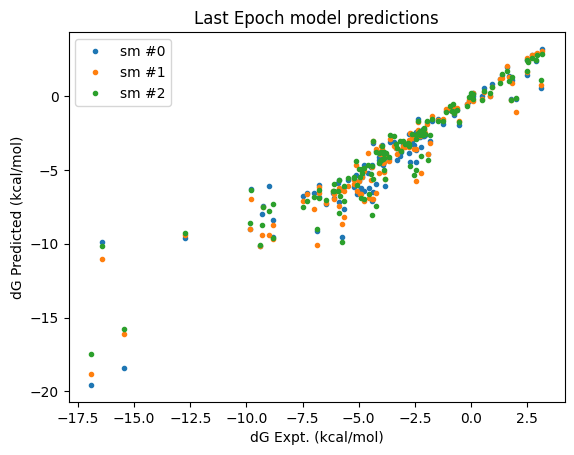

In [200]:
# RMSEs=[]
# MAEs=[]

# for m in [sm]:
for i,m in enumerate(summary_models):
    t_P,t_Y,P,Y=m.get_predictions_from_batches(val_generator, with_np=True)
#     print(torch.flatten(t_Y).detach())
#     print(torch.flatten(t_P).detach())
#     print(torch.flatten(t_Y-t_P).detach())
#     print(torch.flatten(torch.square(t_Y-t_P)).detach())
#     print(torch.flatten(t_P).detach())
#     print(torch.flatten(nn.MSELoss(reduction='none')(t_P,t_Y)).detach())
#     raise()
#     print(m.loss_mse(t_Y, t_P).detach().tolist())

    plt.plot(Y,P, color=f"C{i}", marker=".", linestyle="None", label=f"sm #{i}")
    
plt.gca().set(xlabel='dG Expt. (kcal/mol)', ylabel='dG Predicted (kcal/mol)', title="Last Epoch model predictions")
plt.legend()

In [201]:
print("sm Val. MAE:", multi_model_record.loss_sm_Val[-1])
print("sm Val. RMSE:", multi_model_record.RMSD_sm_Val[-1])

sm Val. MAE: 0.8192956646283468
sm Val. RMSE: 1.2563650608062744


# NN diagram
This is a 3 layer perceptron (2 hidden layers) with BatchNorm before the activation functions.<br>
ReLu is used for most layers, except the second to last one is Sigmoid and the output layer has no activation.
ShiftY is used to try and move <b>untrained</b> predictions in the correct range to make outliers better behaved,
however, with BatchNorm this is no longer needed.<br>
The Max and Min function at the end are also pointless now. They are supposed to prevent NAN loss during training and are leftover from debugging normalization of train/test input features.

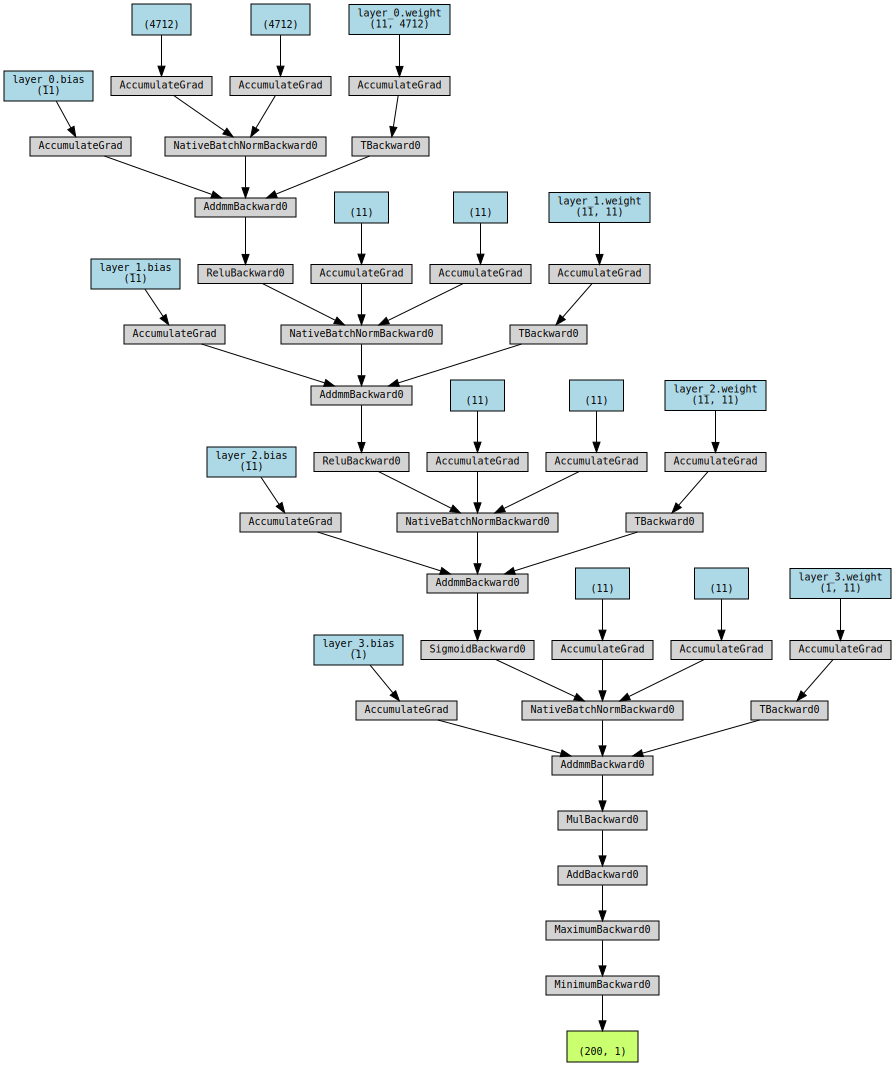

In [13]:
from torchviz import make_dot
x,y=next(iter(all_generator))
p=sm.eval()(x)
make_dot(p, params=dict(list(sm.named_parameters())))#.render("model_architecture", format="png")

# PLS
Do not normalize data to training set in PLS (scale=False), otherwize we can't use this rotation matrix for NN later.<br>
In this case normalizing to the training set actually improces PLS validation slightly.

In [173]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

Train_set = CustomMolModularDataset([ligs[idx] for idx in known_idxs],
                                    normalize_x=normalize_x, X_filter=X_filter,
                                    internal_cache_maxMem_MB=max_cache_Mem_MB)
Train_set.copy_normalization_factors(full_dataset)
Train_set.build_internal_filtered_cache()
Train_gen=torch.utils.data.DataLoader(Train_set, shuffle=False,  batch_size=len(known_idxs))
X_train, Y_train=next(iter(Train_gen))
X_train=X_train.detach().numpy()
Y_train=Y_train.detach().numpy().flatten()

val_dataset = CustomMolModularDataset([ligs[idx] for idx in unknown_idxs],
                                    normalize_x=normalize_x, X_filter=X_filter,
                                    internal_cache_maxMem_MB=max_cache_Mem_MB)
val_generator = torch.utils.data.DataLoader(val_dataset, shuffle=False, batch_size=len(val_dataset))
X_Val, Y_Val = next(iter(val_generator))
X_Val=X_Val.detach().numpy()
Y_Val=Y_Val.detach().numpy().flatten()

# pls = PLSRegression(n_components=20)
# pls.fit(X_train, Y_train)

# #pls.transform(X_test)
# P_Val=pls.predict(X_Val).flatten()
# RMSE=np.sqrt(mean_squared_error(P_Val, Y_Val))
# print(RMSE)
# P_train=pls.predict(X_train).flatten()
# RMSE=np.sqrt(mean_squared_error(P_train, Y_train))
# print(RMSE)

In [174]:
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import scale 

#define cross-validation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# set up variables
mse = []
n = 20 # max PLS components

# Calculate MSE using cross-validation, adding one component at a time
for i in trange(1, n):
    pls = PLSRegression(n_components=i, scale=False)
    score = -1*model_selection.cross_val_score(pls, X_train, Y_train, cv=cv,
               scoring='neg_mean_squared_error').mean()
    mse.append(score)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:21<00:00,  1.12s/it]


(1.0, 2.2)

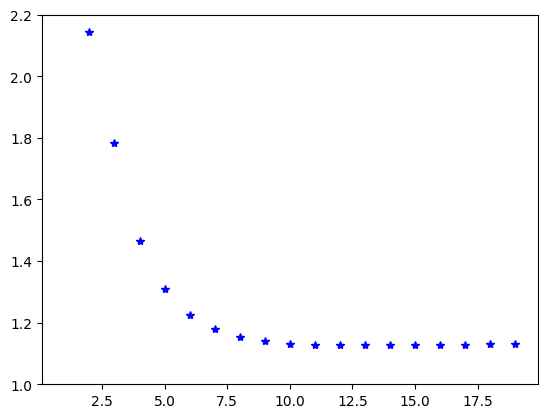

In [175]:
# print(mse)
plt.plot(np.arange(1,20), np.sqrt(mse), "b*")
plt.ylim((1,2.2))

In [177]:
pls = PLSRegression(n_components=11, scale=False)
pls.fit(X_train, Y_train)

P_Val=pls.predict(X_Val)
print("PLS Validation RMSE:", np.sqrt(mean_squared_error(Y_Val, P)))
print("PLS Validation MAE:", mean_absolute_error(Y_Val, P))

PLS Validation RMSE: 1.216127171002098
PLS Validation MAE: 0.7905529274681741


## PLS rotation matrix:
Multiply it with normalized input features.

In [178]:
pls.x_rotations_

array([[-2.87128864e-03,  1.66563297e-03, -1.74984573e-03, ...,
        -2.09299817e-02, -1.37927889e-02, -7.35610938e-03],
       [ 1.25172931e-03, -3.51942114e-03,  3.78179106e-03, ...,
         4.89137872e-04, -5.49951649e-03,  6.23845037e-03],
       [-9.40086273e-03,  1.23864847e-02, -9.61747078e-03, ...,
         1.41256957e-02,  1.57553030e-02, -1.95987886e-02],
       ...,
       [ 3.00401073e-05,  2.12785437e-02, -5.96225066e-02, ...,
         7.52880062e-03, -1.08651130e-02,  3.49687102e-02],
       [ 1.26510933e-02,  1.13297037e-03, -1.68680665e-02, ...,
         3.85351559e-03, -2.86899122e-03, -7.88173485e-03],
       [-7.52360247e-03,  1.90454518e-02, -6.81143664e-03, ...,
        -6.54947226e-03,  1.24945306e-02, -7.77504134e-03]])

# NN Model initied with PLS rotation matrix

In [203]:
n_Epochs = 10000
unfreeze_rotation_at_Epoch = 5000 # will also reset learning rate here to mimick what was implemented in Goettingen

In [205]:
# Derrive a new NN class.
# This one rotates the input features by the PLS rotation matrix before feeding it to the remaining layers from the standard Net class.
# There is no activation function or BatchNorm after the rotation layer.

class RotatedInputNet(Net):
    def __init__(self, *args, **kwargs):
        super(RotatedInputNet, self).__init__(*args, **kwargs)
        
    def init_layers(self):
        super(RotatedInputNet, self).init_layers()
        
        self.rot_layer = nn.Linear(self.inp_width, self.hl_w)
        # rotation layer will initialize separately and will be initially frozen
        self.rot_layer.weight.requires_grad = False
        self.rot_layer.bias.requires_grad = False
        
#         self.PLS_mean = torch.zeros((self.hl_w,1))
#         self.PLS_std = torch.zeros((self.hl_w,1))
        
        # overwrite dimentions of the "first" layer
        self.layers[0] = nn.Linear(self.hl_w, self.hl_w)
        setattr(self, "layer_{}".format(0), self.layers[0])
        nn.init.xavier_uniform_(self.layers[0].weight, gain=nn.init.calculate_gain('relu'))
        
        # also change shape of the first BatchNorm to match
        if(self.use_batchnorms):
            self.batchnorms[0] = nn.BatchNorm1d(self.hl_w)
    
#         for bn in self.batchnorms:
#             print(bn)
#         for l in self.layers:
#             print(l)
#         print()
        
    def forward(self, x):
        x=self.rot_layer(x)
#         print(x.shape)
        return(super(RotatedInputNet, self).forward(x))



# Also reset learning rate when unfreezing.
# Maybe this was what caused improvement in the past when I restarted training in a separate cell after unfreezing?
    def adjust_learning_rate(self):
        """Reduce the learning rate by order of magnitude every self.lr_decay epochs."""
        if(type(self.lr_decay) is tuple): # stochastic gradient descent with warm restarts
            lr_min=self.lr_decay[0]
            lr_max=self.init_lr
            lr_decay_period=self.lr_decay[1]
            
            lr=lr_min + 0.5*(lr_max-lr_min)*(1+np.cos(np.pi*(self.epoch%lr_decay_period)/lr_decay_period))
            
            #print(f"Epoch: {self.epoch} \tlearning rate: {lr}")
            
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = lr
        elif(self.lr_decay>0):
            e = self.epoch
            if(e>=unfreeze_rotation_at_Epoch): # reset the learning rate when unfreezing rotation matrix
                e-=unfreeze_rotation_at_Epoch
            
            lr = self.init_lr * (0.1 ** (e / self.lr_decay))
            
            #print(f"Epoch: {self.epoch} \tlearning rate: {lr}")
            
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = lr

Start setting up models 2023-11-29 00:04:58.880623
There are 4712 features 2023-11-29 00:04:58.881124
Finished setup for summary model 2 2023-11-29 00:04:58.898683
Training for 10000 epochs 2023-11-29 00:04:58.898845


Epoch: 100%|█████████████████████████████████████████████████████████████████████████████████████████▉| 9996/10000 [03:21<00:00, 49.21it/s]

Epoch 9999. Backing up models.


Epoch: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:22<00:00, 49.43it/s]


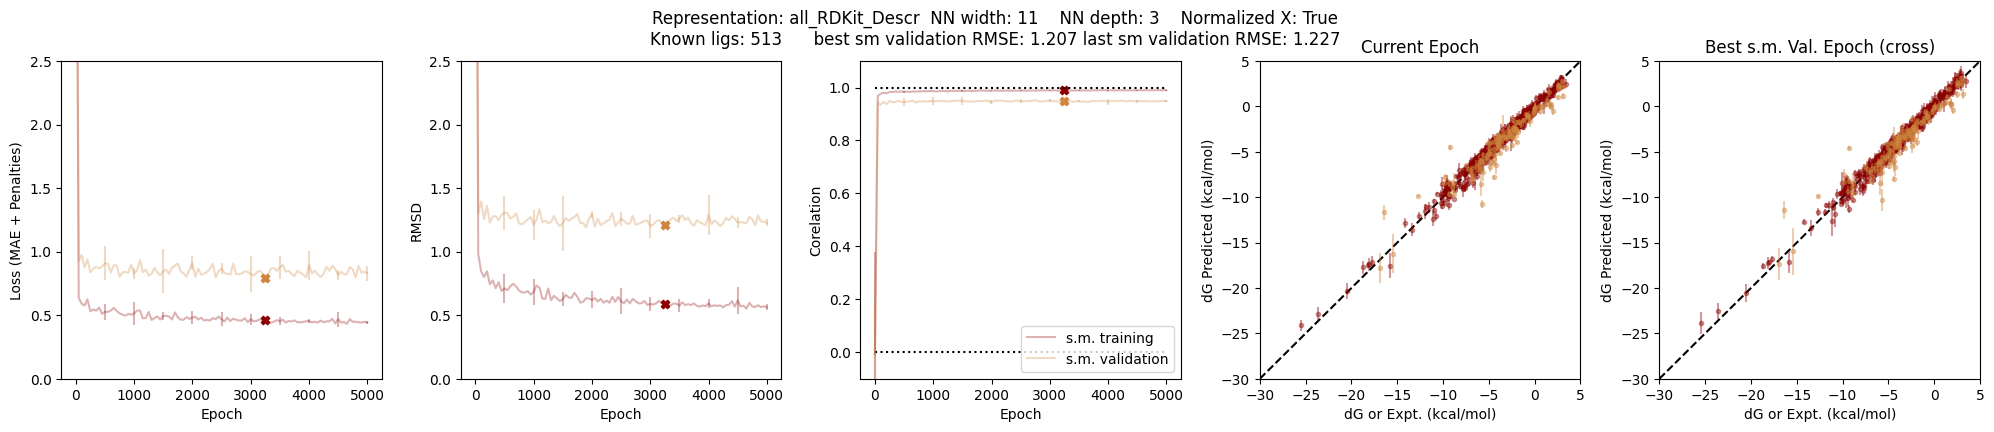

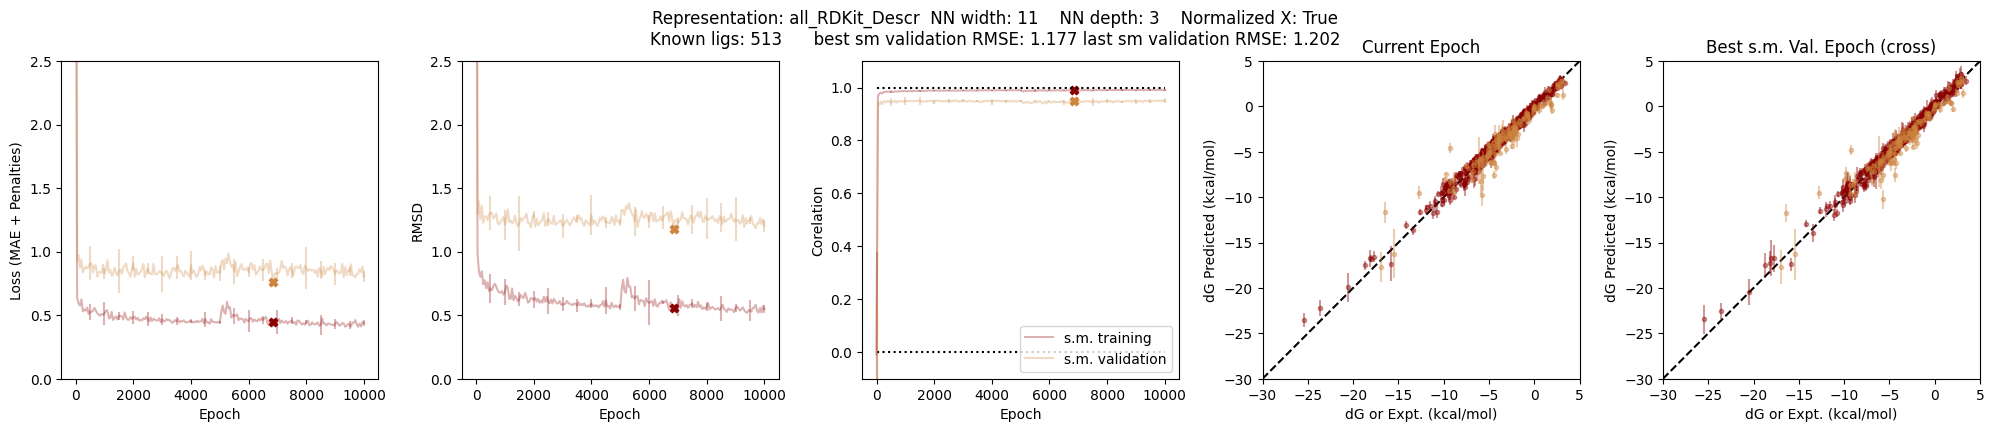

In [208]:
#################
# do the training
#################
print("Start setting up models", datetime.now(), flush=True)

if(predict_all_ligs):
    n_features = full_dataset[0][0].shape[-1]
else:
    #no point normalising or building internal cache for this one, we just want to know # of features it spits out
    tempDS = CustomMolModularDataset([ligs[0]],
                                 normalize_x=False,
                                 X_filter=X_filter,
                                 internal_cache_maxMem_MB=0)
    n_features = tempDS[0][0].shape[-1]
    del tempDS
    _=gc.collect()
known_Y=allYdata[known_idxs]
print("There are", n_features, "features", datetime.now(), flush=True)

models=[]
model_Train_idxs=[]
model_XVal_idxs=[]
split_gen=data_split(known_idxs)
# for drop in range(XVal_blocks):

#     #create model
#     model = Net(inp_width=n_features, hl_w=hl_w, nhl=hl_depth, activation=activation, last_activation=last_activation,
#                 learning_rate=init_learning_rate, lr_decay=learning_rate_decay,
#                 high_binder_cutoff=0, # used for calculation of TPR/FPR
#                 weight_decay=weight_decay, cap_output=cap_output,
#                 weights_distrib_func=weight_func, drop_p=p_dropout, use_batchnorms=use_batchnorms,
#                 noise=noise, shiftY=shiftY).to(device)

#     #create training, cross validation, and test data
#     Train_indeces, XVal_indeces = next(split_gen)

#     #save as indexes within known_idxs array
#     model_Train_idxs.append(Train_indeces)
#     model_XVal_idxs.append(XVal_indeces)

#     Train_indeces = known_idxs[Train_indeces] #convert indexing into the ligs array
#     XVal_indeces  = known_idxs[XVal_indeces]  #convert indexing into the ligs array

#     Train_set = CustomMolModularDataset([ligs[idx] for idx in Train_indeces],
#                                         normalize_x=normalize_x, X_filter=X_filter,
#                                         internal_cache_maxMem_MB=max_cache_Mem_MB)
#     XVal_set  = CustomMolModularDataset([ligs[idx] for idx in XVal_indeces ],
#                                         normalize_x=normalize_x, X_filter=X_filter,
#                                         internal_cache_maxMem_MB=max_cache_Mem_MB)
#     Train_set.copy_normalization_factors(full_dataset)
#     XVal_set.copy_normalization_factors(full_dataset)

#     #build_internal_filtered_cache
#     Train_set.build_internal_filtered_cache()
#     XVal_set.build_internal_filtered_cache()

#     #create training, cross validation, and test datagens
#     model.training_generator            = torch.utils.data.DataLoader(Train_set, shuffle=True,  batch_size=batchsize)
#     model.training_generator_no_shuffle = torch.utils.data.DataLoader(Train_set, shuffle=False, batch_size=eval_batchsize)
#     model.crossvalidation_generator     = torch.utils.data.DataLoader(XVal_set,  shuffle=False, batch_size=eval_batchsize)

#     #add tracking of validation ligands
#     if(validation_db_file is not None):
#         model.test_generator            = val_generator

#     del Train_set, XVal_set

#     models.append(model)
#     print("Finished setup for model", drop, datetime.now())

summary_models=[]
Train_set = CustomMolModularDataset([ligs[idx] for idx in known_idxs],
                                    normalize_x=normalize_x, X_filter=X_filter,
                                    internal_cache_maxMem_MB=max_cache_Mem_MB)
Train_set.copy_normalization_factors(full_dataset)
Train_set.build_internal_filtered_cache()
sm_gen_shuffle=torch.utils.data.DataLoader(Train_set, shuffle=True,  batch_size=batchsize)
sm_gen_no_shuffle=torch.utils.data.DataLoader(Train_set, shuffle=False,  batch_size=batchsize)

if(train_summary_model):
    for drop in range(XVal_blocks):
        sm = RotatedInputNet(inp_width=n_features, hl_w=hl_w, nhl=hl_depth, activation=activation, last_activation=last_activation,
                learning_rate=init_learning_rate, lr_decay=learning_rate_decay,
                high_binder_cutoff=0, weight_decay=weight_decay, cap_output=cap_output,
                weights_distrib_func=weight_func, drop_p=p_dropout, use_batchnorms=use_batchnorms,
                noise=noise, shiftY=shiftY).to(device)
        
        ########
        # initilize the first layer from PLS
        state_dict = sm.state_dict()
        state_dict['rot_layer.weight'] = torch.from_numpy(pls.x_rotations_.transpose())
        state_dict['rot_layer.bias'] = torch.zeros(state_dict['rot_layer.bias'].shape)
        sm.load_state_dict(state_dict)
        # freeze this rotation matrix, we will unfreeze it later for more training
        sm.rot_layer.weight.requires_grad = False
        sm.rot_layer.bias.requires_grad = False
        ########

        sm.training_generator            = sm_gen_shuffle
        sm.training_generator_no_shuffle = sm_gen_no_shuffle

        #add tracking of validation ligands
        if(validation_db_file is not None):
            sm.test_generator            = val_generator

        summary_models.append(sm)

    print("Finished setup for summary model", drop, datetime.now())
del Train_set

multi_model_record = MultiTrainingRecord()
if (validation_db_file is None):
    print("There is no validation dataset provided. Disabling validation metrics.")
    multi_model_record.datasubsets=["Train", "Train_err", "XVal"]
    multi_model_record.sm_datasubsets=["sm_Train", "sm_Train_err"]

print("Training for", n_Epochs, "epochs", datetime.now(), flush=True)
pbar = trange(0, n_Epochs, desc="Epoch")
for ep in pbar:
    
    # unfreeze rotation layer and start training it
    if(ep == unfreeze_rotation_at_Epoch):
        for drop in range(XVal_blocks):
            sm.rot_layer.weight.requires_grad = True
            sm.rot_layer.bias.requires_grad = True
    
    #train K_fold models
    for drop in range(XVal_blocks):
#         models[drop].train_epoch(eval_every=eval_every)

        if(train_summary_model):
            summary_models[drop].train_epoch(eval_every=eval_every)

    if ep%eval_every == eval_every-1 or ep == 0:            
        all_Y_known=torch.zeros((len(known_idxs), 1), dtype=torch.float, device=device)
        multi_P_XVal=torch.zeros((len(known_idxs), 1), dtype=torch.float, device=device)
#             multi_P_eval=torch.zeros((len(evaluation_half), 1, XVal_blocks), dtype=torch.float, device=device)
#         for drop in range(XVal_blocks):
#             test_ndxs=model_XVal_idxs[drop]
#             P_XVal, Y_XVal = models[drop].get_predictions_from_batches(models[drop].crossvalidation_generator, with_np=False)
#             multi_P_XVal[test_ndxs,:]= P_XVal
#             all_Y_known[test_ndxs,:] = Y_XVal

#         np_all_Y_known=all_Y_known.detach().cpu().numpy()[:,0]
#         np_multi_P_XVal=multi_P_XVal.detach().cpu().numpy()[:,0]

#         XVal_loss=models[0].loss_fn(all_Y_known, multi_P_XVal).detach().cpu().tolist()
#         XVal_RMSE=torch.sqrt(models[0].loss_mse(all_Y_known, multi_P_XVal)).detach().cpu().numpy()
#         XVal_Cor=np.corrcoef(np_all_Y_known.flatten(), np_multi_P_XVal.flatten())[0,1]
#         XVal_KT=sp.stats.kendalltau(np_all_Y_known.flatten(), np_multi_P_XVal.flatten())[0]


#         #true and false positive rates + AUC
#         with warnings.catch_warnings():
#             warnings.simplefilter("ignore")
#             #XVal_FP, XVal_TP, XVal_AUC = get_FPR_TPR_AUC(np_all_Y_known, np_multi_P_XVal, high_binder_cutoff)
#             XVal_FP, XVal_TP = get_FPR_and_TPR(np_all_Y_known, np_multi_P_XVal, high_binder_cutoff)
#             XVal_AUC = get_fixed_ROC_AUC(np_all_Y_known, np_multi_P_XVal, P_err=None, cut=high_binder_cutoff)

#         #save state at best XVal loss
#         if(ep>0 and XVal_loss < np.min(multi_model_record.loss_XVal)):
#             for m in models:
#                 m.cache_state()

        #95 % confidence interval assuming gaussian error model
        #confinterval= lambda a: st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))[0]-np.mean(a)

        multi_model_record.epoch.append(ep)
#         multi_model_record.loss_XVal.append(XVal_loss)
#         multi_model_record.RMSD_XVal.append(XVal_RMSE)
#         multi_model_record.Cor_XVal.append(XVal_Cor)
#         multi_model_record.kendalltau_XVal.append(XVal_KT)

#         multi_model_record.TP_XVal.append(XVal_TP)
#         multi_model_record.FP_XVal.append(XVal_FP)
#         multi_model_record.AUC_XVal.append(XVal_AUC)

#         #all the other metrics taken from individual models
#         func_mean = lambda n : np.mean([getattr(m.record, n)[-1] for m in models])
#         func_err = lambda n : confinterval([getattr(m.record, n)[-1] for m in models])
#         for d in multi_model_record.datasubsets:
#             srcd=d
#             f=func_mean
#             if(d=="XVal" or "summary_model" in d or d=="unknown"):
#                 continue; #these are set manually
#             if((d=="Val" or d=="Val_err") and validation_db_file is None):
#                 continue; # can't record validation metrics if there is no validation dataset
#             if ("_err" in d):
#                 srcd=d[:-4]
#                 f=func_err

#             for metric in multi_model_record.metrics:
#                 atrname=metric+'_'+d
#                 srcname=metric+'_'+srcd
#                 try:
#                     getattr(multi_model_record, atrname).append(f(srcname))
#                 except Exception as e:
#                     print(f"d={d}\t atrname={atrname}\t srcname={srcname}", flush=True)
#                     raise(e);

        if(train_summary_model):
            sm_func_mean = lambda n : np.mean([getattr(sm.record, n)[-1] for sm in summary_models])
            sm_func_err = lambda n : confinterval([getattr(sm.record, n)[-1] for sm in summary_models])
            for d in multi_model_record.sm_datasubsets:
                for metric in multi_model_record.metrics:
                    srcd=d[3:]
                    f=sm_func_mean
                    if ("_err" in d):
                        srcd=d[3:-4]
                        f=sm_func_err

                    atrname=metric+'_'+d
                    srcname=metric+'_'+srcd
                    getattr(multi_model_record, atrname).append(f(srcname))


        #save state at best Val loss for summary_model
        if(train_summary_model):
            if(ep>0 and multi_model_record.loss_sm_Val[-1] < np.min(multi_model_record.loss_sm_Val[:-1])):
                for sm in summary_models:
                    sm.cache_state()



        if(show_progress):
#             if(validation_db_file is None):
#                 print(f"\tEpoch: {ep}\t train_loss={multi_model_record.loss_Train[-1]}\t XVal_RMSE={XVal_RMSE}", end="")
#             else:
#                 print(f"\tEpoch: {ep}\t train_loss={multi_model_record.loss_Train[-1]:.4f}+-{multi_model_record.loss_Train_err[-1]:.4f}\t XVal_RMSE={XVal_RMSE:.4f}\t Val_RMSE={multi_model_record.RMSD_Val[-1]:.4f}+-{multi_model_record.RMSD_Val_err[-1]:.4f}", end="")

            if(train_summary_model):
                if(validation_db_file is None):
                    print(f"\t sm_train_loss={multi_model_record.loss_sm_Train[-1]:.4}", end="")
                else:
                    print(f"\t sm_train_loss={multi_model_record.loss_sm_Train[-1]:.4}\t sm_Val_RMSE={multi_model_record.RMSD_sm_Val[-1]:.4f}", end="")

            print("", flush=True)


#     # check for nans and restart training if detected
#     if(not np.isfinite(multi_model_record.loss_Train[-1]) or not np.isfinite(XVal_RMSE)):
#         print([m.record.loss_XVal for m in models])
#         print([m.record.loss_Val for m in models])
#         raise(RuntimeError("Nan in metrics"))                    

    #plot all models at once
    if ep%plot_every == plot_every-1 or ep==n_Epochs-1:

        fig=plt.figure(figsize=(20,8))
        sp_grid = gridspec.GridSpec(2, 5)

        ax = plt.subplot(sp_grid[0,0])
        plt.ylim(0, 2.5)
        rec = multi_model_record
#         bi=np.argmin(rec.loss_XVal)
        if(validation_db_file is not None):
            sm_bi=np.argmin(rec.loss_sm_Val)

#         ax.errorbar(rec.epoch[::10], rec.loss_Train[::10], yerr=rec.loss_Train_err[::10], color=train_clr, alpha=0.3, linestyle="none")
#         ax.plot(rec.epoch, rec.loss_Train, alpha=0.3, label="training", color=train_clr)
#         ax.plot(rec.epoch, rec.loss_XVal, alpha=0.3, label="cross validation", color=Xval_clr)
#         ax.scatter(rec.epoch[bi], rec.loss_Train[bi], color=train_clr, marker="*")
#         ax.scatter(rec.epoch[bi], rec.loss_XVal[bi], color=Xval_clr, marker="*")
#         eprange=[0,ep]
#         MAE_best=[rec.loss_XVal[bi],rec.loss_XVal[bi]]
#         MAE_last=[rec.loss_XVal[-1],rec.loss_XVal[-1]]
#         ax.plot(eprange, MAE_best, '--k', zorder=0, alpha=0.3, label=None)
#         ax.plot(eprange, MAE_last, '--k', zorder=0, alpha=0.3, label=None)
#         if(validation_db_file is not None):
#             ax.errorbar(rec.epoch[::10], rec.loss_Val[::10], yerr=rec.loss_Val_err[::10], color=unkn_clr, alpha=0.3, linestyle="none")
#             ax.plot(rec.epoch, rec.loss_Val, alpha=0.3, label="validation", color=unkn_clr)
#             ax.scatter(rec.epoch[bi], rec.loss_Val[bi], color=unkn_clr, marker="*")
        if(train_summary_model):
            ax.errorbar(rec.epoch[::10], rec.loss_sm_Train[::10], yerr=rec.loss_sm_Train_err[::10], color=summary_train_clr, alpha=0.3, linestyle="none")
            ax.plot(rec.epoch, rec.loss_sm_Train, alpha=0.3, label="s.m. training", color=summary_train_clr)
            ax.scatter(rec.epoch[sm_bi], rec.loss_sm_Train[sm_bi], color=summary_train_clr, marker="X")
            if(validation_db_file is not None):
                ax.errorbar(rec.epoch[::10], rec.loss_sm_Val[::10], yerr=rec.loss_sm_Val_err[::10], color=summary_unkn_clr, alpha=0.3, linestyle="none")
                ax.plot(rec.epoch, rec.loss_sm_Val, alpha=0.3, label="s.m. validation", color=summary_unkn_clr)
                ax.scatter(rec.epoch[sm_bi], rec.loss_sm_Val[sm_bi], color=summary_unkn_clr, marker="X")


        ax.set(xlabel='Epoch', ylabel='Loss (MAE + Penalties)')

        ax = plt.subplot(sp_grid[0,1])
        plt.ylim(0, 2.5)
#         ax.errorbar(rec.epoch[::10], rec.RMSD_Train[::10], yerr=rec.RMSD_Train_err[::10], color=train_clr, alpha=0.3, linestyle="none")
#         ax.plot(rec.epoch, rec.RMSD_Train, alpha=0.3, label="training", color=train_clr)
#         ax.plot(rec.epoch, rec.RMSD_XVal, alpha=0.3, label="cross validation", color=Xval_clr)
#         ax.scatter(rec.epoch[bi], rec.RMSD_Train[bi], color=train_clr, marker="*")
#         ax.scatter(rec.epoch[bi], rec.RMSD_XVal[bi], color=Xval_clr, marker="*")
        ax.set(xlabel='Epoch', ylabel='RMSD')
#         if(validation_db_file is not None):
#             ax.errorbar(rec.epoch[::10], rec.RMSD_Val[::10], yerr=rec.RMSD_Val_err[::10], color=unkn_clr, alpha=0.3, linestyle="none")
#             ax.plot(rec.epoch, rec.RMSD_Val, alpha=0.3, label="validation", color=unkn_clr)
#             ax.scatter(rec.epoch[bi], rec.RMSD_Val[bi], color=unkn_clr, marker="*")
        if(train_summary_model):
            ax.errorbar(rec.epoch[::10], rec.RMSD_sm_Train[::10], yerr=rec.RMSD_sm_Train_err[::10], color=summary_train_clr, alpha=0.3, linestyle="none")
            ax.plot(rec.epoch, rec.RMSD_sm_Train, alpha=0.3, label="s.m. training", color=summary_train_clr)
            ax.scatter(rec.epoch[sm_bi], rec.RMSD_sm_Train[sm_bi], color=summary_train_clr, marker="X")
            if(validation_db_file is not None):
                ax.errorbar(rec.epoch[::10], rec.RMSD_sm_Val[::10], yerr=rec.RMSD_sm_Val_err[::10], color=summary_unkn_clr, alpha=0.3, linestyle="none")
                ax.plot(rec.epoch, rec.RMSD_sm_Val, alpha=0.3, label="s.m. validation", color=summary_unkn_clr)
                ax.scatter(rec.epoch[sm_bi], rec.RMSD_sm_Val[sm_bi], color=summary_unkn_clr, marker="X")

        ax = plt.subplot(sp_grid[0,2])
        plt.ylim(-0.1, 1.1)
        plt.hlines(0, np.min(rec.epoch), np.max(rec.epoch), colors='k', linestyles='dotted', label='')
        plt.hlines(1, np.min(rec.epoch), np.max(rec.epoch), colors='k', linestyles='dotted', label='')
#         ax.errorbar(rec.epoch[::10], rec.Cor_Train[::10], yerr=rec.Cor_Train_err[::10], color=train_clr, alpha=0.3, linestyle="none")
#         ax.plot(rec.epoch, rec.Cor_Train, alpha=0.3, label="training", color=train_clr)
#         ax.plot(rec.epoch, rec.Cor_XVal, alpha=0.3, label="cross validation", color=Xval_clr)
#         ax.scatter(rec.epoch[bi], rec.Cor_Train[bi], color=train_clr, marker="*")
#         ax.scatter(rec.epoch[bi], rec.Cor_XVal[bi], color=Xval_clr, marker="*")
        ax.set(xlabel='Epoch', ylabel='Corelation')
#         if(validation_db_file is not None):
#             ax.errorbar(rec.epoch[::10], rec.Cor_Val[::10], yerr=rec.Cor_Val_err[::10], color=unkn_clr, alpha=0.3, linestyle="none")
#             ax.plot(rec.epoch, rec.Cor_Val, alpha=0.3, label="validation", color=unkn_clr)
#             ax.scatter(rec.epoch[bi], rec.Cor_Val[bi], color=unkn_clr, marker="*")
        if(train_summary_model):
            ax.errorbar(rec.epoch[::10], rec.Cor_sm_Train[::10], yerr=rec.Cor_sm_Train_err[::10], color=summary_train_clr, alpha=0.3, linestyle="none")
            ax.plot(rec.epoch, rec.Cor_sm_Train, alpha=0.3, label="s.m. training", color=summary_train_clr)
            ax.scatter(rec.epoch[sm_bi], rec.Cor_sm_Train[sm_bi], color=summary_train_clr, marker="X")
            if(validation_db_file is not None):
                ax.errorbar(rec.epoch[::10], rec.Cor_sm_Val[::10], yerr=rec.Cor_sm_Val_err[::10], color=summary_unkn_clr, alpha=0.3, linestyle="none")
                ax.plot(rec.epoch, rec.Cor_sm_Val, alpha=0.3, label="s.m. validation", color=summary_unkn_clr)
                ax.scatter(rec.epoch[sm_bi], rec.Cor_sm_Val[sm_bi], color=summary_unkn_clr, marker="X")

        plt.legend()



        #prepare data across multiple models            
        multi_P_XVal=torch.zeros(all_Y_known.shape, dtype=torch.float)
        best_P_XVal=torch.zeros(all_Y_known.shape, dtype=torch.float)
        multi_P_Train = np.zeros((all_Y_known.shape[0], XVal_blocks-1)) #indexed by [data, repeat]
        best_P_Train  = np.zeros((all_Y_known.shape[0], XVal_blocks-1)) #indexed by [data, repeat]

#         for drop in range(XVal_blocks): #go through each block
#             test_ndxs=model_XVal_idxs[drop]

#             P_XVal, Y_XVal = models[drop].get_predictions_from_batches(models[drop].crossvalidation_generator, with_np=False)
#             multi_P_XVal[test_ndxs,:]=P_XVal.detach().cpu()

#             models[drop].restore_state() #best epoch so far
#             P_XVal, Y_XVal  = models[drop].get_predictions_from_batches(models[drop].crossvalidation_generator, with_np=False)
#             models[drop].restore_state() #reset to current epoch
#             best_P_XVal[test_ndxs,:]=P_XVal.detach().cpu()



#             #for training predictions,
#             #go through each model
#             for k, m in enumerate(models):               
#                 j=k # j<drop
#                 if(k==drop):
#                     continue;
#                 elif(k>drop):
#                     j=k-1

#                 P_train, Y_train = m.get_predictions_from_batches(models[drop].crossvalidation_generator, with_np=False)
#                 multi_P_Train[test_ndxs, j] = P_train.detach().cpu().numpy()[:,0]

#                 m.restore_state() #best epoch so far
#                 P_train, Y_train = m.get_predictions_from_batches(models[drop].crossvalidation_generator, with_np=False)
#                 m.restore_state() #reset to current epoch
#                 best_P_Train[test_ndxs, j] = P_train.detach().cpu().numpy()[:,0]


#         multi_P_XVal = multi_P_XVal.detach().cpu().numpy()[:,0] #convert to numpy, ordered like known_Y
#         multi_P_Train_mean= np.mean(multi_P_Train, axis=-1) # ordered like known_Y
#         multi_P_Train_err = [confinterval(multi_P_Train[g,:]) for g in range(multi_P_Train.shape[0])]

#         best_P_XVal = best_P_XVal.detach().cpu().numpy()[:,0] #convert to numpy, ordered like known_Y
#         best_P_Train_mean = np.mean(best_P_Train, axis=-1) # ordered like known_Y
#         best_P_Train_err = [confinterval(best_P_Train[g,:]) for g in range(best_P_Train.shape[0])]


#         if(validation_db_file is not None):
#             multi_P_Val = np.zeros((n_val_ligs, XVal_blocks)) #indexed by [data, repeat]
#             best_P_Val  = np.zeros((n_val_ligs, XVal_blocks)) #indexed by [data, repeat]

#             for drop in range(XVal_blocks): #go through each block

#                 P, Y_Val = models[drop].get_predictions_from_batches(models[drop].test_generator, with_np=False)
#                 multi_P_Val[:,drop]=P.detach().cpu().numpy()[:,0]

#                 models[drop].restore_state() #best epoch so far
#                 P, Y_Val = models[drop].get_predictions_from_batches(models[drop].test_generator, with_np=False)
#                 models[drop].restore_state() #reset to current epoch
#                 best_P_Val[:,drop]=P.detach().cpu().numpy()[:,0]

#             multi_P_Val_mean=np.mean(multi_P_Val, axis=-1)
#             multi_P_Val_err = np.array([confinterval(multi_P_Val[g,:]) for g in range(best_P_Val.shape[0])])
#             best_P_Val_mean=np.mean(best_P_Val, axis=-1)
#             best_P_Val_err = np.array([confinterval(best_P_Val[g,:]) for g in range(best_P_Val.shape[0])])
#             Y_Val = Y_Val.detach().cpu().numpy()

#             del multi_P_Val, best_P_Val


#         #plot data
#         ax = plt.subplot(sp_grid[0,3])
#         lims=(-30,5)
#         plt.ylim(lims[0], lims[1])
#         plt.xlim(lims[0], lims[1])
#         ax.errorbar(known_Y, multi_P_Train_mean, yerr=multi_P_Train_err, color=train_clr, marker=".", ls='', alpha=0.2, zorder=1)
#         ax.scatter(known_Y, multi_P_XVal, color=Xval_clr, marker=".", alpha=0.4, zorder=2)
#         if(validation_db_file is not None):
#             ax.errorbar(Y_Val, multi_P_Val_mean, yerr=multi_P_Val_err, color=unkn_clr, marker=".", ls='', alpha=0.2, zorder=3)            
#         diag = np.linspace(lims[0],lims[1], 10)
#         plt.plot(diag, diag, '--k', zorder=0)
# #         plt.vlines(high_binder_cutoff, lims[0], lims[1], colors='k', linestyles='dotted', label='')
# #         plt.hlines(high_binder_cutoff, lims[0], lims[1], colors='k', linestyles='dotted', label='')
#         ax.set(xlabel='dG Expt. (kcal/mol)', ylabel='dG Predicted (kcal/mol)', title="Current Epoch")



#         #plot best data
#         ax = plt.subplot(sp_grid[0,4])
#         plt.ylim(lims[0], lims[1])
#         plt.xlim(lims[0], lims[1])
#         ax.errorbar(known_Y, best_P_Train_mean, yerr=best_P_Train_err, color=train_clr, marker=".", ls='', alpha=0.2, zorder=1)
#         ax.scatter(known_Y, best_P_XVal, color=Xval_clr, marker=".", alpha=0.4, zorder=2)
#         if(validation_db_file is not None):
#             ax.errorbar(Y_Val, best_P_Val_mean, yerr=best_P_Val_err, color=unkn_clr, marker=".", ls='', alpha=0.2, zorder=3)
#         diag = np.linspace(lims[0],lims[1], 10)
#         plt.plot(diag, diag, '--k', zorder=0)
# #         plt.vlines(high_binder_cutoff, lims[0], lims[1], colors='k', linestyles='dotted', label='')
# #         plt.hlines(high_binder_cutoff, lims[0], lims[1], colors='k', linestyles='dotted', label='')
#         ax.set(xlabel='dG Expt. (kcal/mol)', ylabel='dG Predicted (kcal/mol)', title="Best XVal. Epoch (star)")


        # plot currect and best summary_model data too
        if(train_summary_model):
            #gather summary model data
            sm_multi_P_Val = np.zeros((n_val_ligs, XVal_blocks)) #indexed by [data, repeat]
            sm_best_P_Val  = np.zeros((n_val_ligs, XVal_blocks)) #indexed by [data, repeat]
            sm_multi_P_Train = np.zeros((all_Y_known.shape[0], XVal_blocks)) #indexed by [data, repeat]
            sm_best_P_Train  = np.zeros((all_Y_known.shape[0], XVal_blocks)) #indexed by [data, repeat]

            for drop in range(XVal_blocks): #go through each block
                summary_model=summary_models[drop]

                P, Y_Train = summary_model.get_predictions_from_batches(summary_model.training_generator_no_shuffle, with_np=False)
                sm_multi_P_Train[:,drop]=P.detach().cpu().numpy()[:,0]
                if(validation_db_file is not None): # validation
                    P, Y_Val = summary_model.get_predictions_from_batches(summary_model.test_generator, with_np=False)
                    sm_multi_P_Val[:,drop]=P.detach().cpu().numpy()[:,0]


                summary_model.restore_state() #best epoch so far
                P, Y_Train = summary_model.get_predictions_from_batches(summary_model.training_generator_no_shuffle, with_np=False)
                sm_best_P_Train[:,drop]=P.detach().cpu().numpy()[:,0]
                if(validation_db_file is not None): # validation
                    P, Y_Val = summary_model.get_predictions_from_batches(summary_model.test_generator, with_np=False)
                    sm_best_P_Val[:,drop]=P.detach().cpu().numpy()[:,0]
                summary_model.restore_state() #reset to current epoch

            sm_multi_P_Train_mean=np.mean(sm_multi_P_Train, axis=-1)
            sm_multi_P_Train_err = np.array([confinterval(sm_multi_P_Train[g,:]) for g in range(sm_multi_P_Train.shape[0])])
            sm_best_P_Train_mean=np.mean(sm_best_P_Train, axis=-1)
            sm_best_P_Train_err = np.array([confinterval(sm_best_P_Train[g,:]) for g in range(sm_best_P_Train.shape[0])])

            sm_multi_P_Val_mean=np.mean(sm_multi_P_Val, axis=-1)
            sm_multi_P_Val_err = np.array([confinterval(sm_multi_P_Val[g,:]) for g in range(sm_multi_P_Val.shape[0])])
            sm_best_P_Val_mean=np.mean(sm_best_P_Val, axis=-1)
            sm_best_P_Val_err = np.array([confinterval(sm_best_P_Val[g,:]) for g in range(sm_best_P_Val.shape[0])])

            Y_Train = Y_Train.detach().cpu().numpy()
            Y_Val = Y_Val.detach().cpu().numpy()


            # current plot
            ax = plt.subplot(sp_grid[0,3])
            lims=(-30,5)
            plt.ylim(lims[0], lims[1])
            plt.xlim(lims[0], lims[1])                
            ax.errorbar(Y_Train, sm_multi_P_Train_mean, yerr=sm_multi_P_Train_err, color=summary_train_clr, marker=".", alpha=0.4, zorder=1, ls='')
            if(validation_db_file is not None):
                ax.errorbar(Y_Val, sm_multi_P_Val_mean, yerr=sm_multi_P_Val_err, color=summary_unkn_clr, marker=".", alpha=0.4, zorder=2, ls='')
            diag = np.linspace(lims[0],lims[1], 10)
            plt.plot(diag, diag, '--k', zorder=0)
#             plt.vlines(high_binder_cutoff, lims[0], lims[1], colors='k', linestyles='dotted', label='')
#             plt.hlines(high_binder_cutoff, lims[0], lims[1], colors='k', linestyles='dotted', label='')
            ax.set(xlabel='dG or Expt. (kcal/mol)', ylabel='dG Predicted (kcal/mol)', title="Current Epoch")

            # best plot
            ax = plt.subplot(sp_grid[0,4])
            lims=(-30,5)
            plt.ylim(lims[0], lims[1])
            plt.xlim(lims[0], lims[1])
            ax.errorbar(Y_Train, sm_best_P_Train_mean, yerr=sm_best_P_Train_err, color=summary_train_clr, marker=".", alpha=0.4, zorder=1, ls='')
            if(validation_db_file is not None):
                ax.errorbar(Y_Val, sm_best_P_Val_mean, yerr=sm_best_P_Val_err, color=summary_unkn_clr, marker=".", alpha=0.4, zorder=2, ls='')
            diag = np.linspace(lims[0],lims[1], 10)
            plt.plot(diag, diag, '--k', zorder=0)
#             plt.vlines(high_binder_cutoff, lims[0], lims[1], colors='k', linestyles='dotted', label='')
#             plt.hlines(high_binder_cutoff, lims[0], lims[1], colors='k', linestyles='dotted', label='')
            ax.set(xlabel='dG or Expt. (kcal/mol)', ylabel='dG Predicted (kcal/mol)', title="Best s.m. Val. Epoch (cross)")


        fig.suptitle("Representation: {:<15s}  NN width: {:<4d}  NN depth: {:<4d} Normalized X: {}\nKnown ligs: {:<8d} best sm validation RMSE: {:.3f} last sm validation RMSE: {:.3f}".format(
                     dr_name, hl_w, hl_depth, normalize_x, len(known_idxs), rec.RMSD_sm_Val[sm_bi], rec.RMSD_sm_Val[-1]), y=0.95)

        plt.tight_layout()
        plt.gcf().canvas.draw()
        if(save_plot):
            fig.savefig(save_plot)

        #plt.show();



    if ep%backup_models_every == backup_models_every-1:
        print(f"Epoch {ep}. Backing up models.", flush=True)
        os.makedirs(save_folder+"/training_models", exist_ok=True)
#         for i_m, m in enumerate(models):
#             torch.save(m.state_dict(), save_folder+f"/training_models/model_{i_m}_training.ptmod")
#             m.restore_state() # flip to best state of the model
#             torch.save(m.state_dict(), save_folder+f"/training_models/model_{i_m}_best_so_far.ptmod")
#             m.restore_state() # restore current state
        if(train_summary_model):
            for i_m, summary_model in enumerate(summary_models):
                torch.save(summary_model.state_dict(), save_folder+f"/training_models/summary_model_{i_m}_training.ptmod")
                summary_model.restore_state() # flip to best state of the model
                torch.save(summary_model.state_dict(), save_folder+f"/training_models/summary_model_{i_m}_best_so_far.ptmod")
                summary_model.restore_state() # restore current state

        pickle.dump( multi_model_record.metrics, open(save_folder+f"/training_models/training_metrics.pickle", "wb" ) )
        #pickle.dump( (final_Pred_KFold), open(save_folder+f"/training_models/predictions_current_{settings_hash}_Ep{ep}_training.pickle", "wb" ) )


        if(predict_all_ligs):
#             best_Pred_KFold=[]
#             for m in models:
#                 m.restore_state() # flip to best state of the model
#                 best_P, best_Y = m.get_predictions_from_batches(all_generator, with_np=False)
#                 m.restore_state() # restore current state
#                 best_Pred_KFold.append(best_P.detach().cpu().numpy()[:,0])
#             best_Pred_KFold = np.vstack(best_Pred_KFold)
#             best_Pred_KFold = ( np.mean(best_Pred_KFold, axis=0),  np.std(best_Pred_KFold, axis=0)/np.sqrt(XVal_blocks))
#             multi_model_record.best_pred=best_Pred_KFold
#             pickle.dump( (best_Pred_KFold), open(save_folder+f"/training_models/predictions_best_Ep{ep}_training.pickle", "wb" ) )

            if(train_summary_model):
                best_Pred_sm=[]
                for summary_model in summary_models:
                    summary_model.restore_state()
                    best_P, best_Y = summary_model.get_predictions_from_batches(all_generator, with_np=False)
                    summary_model.restore_state()
                    best_Pred_sm.append(best_P.detach().cpu().numpy()[:,0])
                best_Pred_sm = np.vstack(best_Pred_sm)
                best_Pred_sm = ( np.mean(best_Pred_sm, axis=0),  np.std(best_Pred_sm, axis=0)/np.sqrt(XVal_blocks))
                multi_model_record.summary_model_best_pred = best_Pred_sm
                pickle.dump( best_Pred_sm, open(save_folder+f"/training_models/summary_model_predictions_best_Ep{ep}_training.pickle", "wb" ) )
        else:
            multi_model_record.best_pred=None

# #save the models
# print("Training done. Saving models.", flush=True)
# os.makedirs(save_folder, exist_ok=True)
# # torch.save(summary_model.state_dict(), save_folder+"/summary_model.ptmod")
# for i_m, m in enumerate(models):
#     torch.save(m.state_dict(), save_folder+f"/model_{i_m}_ep_{n_Epochs}.ptmod")

if(predict_all_ligs):
#     best_Pred_KFold=[]
#     for m in models:
#         m.restore_state() # flip to best state of the model
#         best_P, best_Y = m.get_predictions_from_batches(all_generator, with_np=False)
#         m.restore_state() # restore current state
#         best_Pred_KFold.append(best_P.detach().cpu().numpy()[:,0])
#     best_Pred_KFold = np.vstack(best_Pred_KFold)
#     multi_model_record.best_pred=( np.mean(best_Pred_KFold, axis=0),  np.std(best_Pred_KFold, axis=0)/np.sqrt(XVal_blocks))
    if(train_summary_model):
        best_Pred_sm=[]
        for summary_model in summary_models:
            summary_model.restore_state()
            best_P, best_Y = summary_model.get_predictions_from_batches(all_generator, with_np=False)
            summary_model.restore_state()
            best_Pred_sm.append(best_P.detach().cpu().numpy()[:,0])
        best_Pred_sm = np.vstack(best_Pred_sm)
        best_Pred_sm = ( np.mean(best_Pred_sm, axis=0),  np.std(best_Pred_sm, axis=0)/np.sqrt(XVal_blocks))
        multi_model_record.summary_model_best_pred = best_Pred_sm
else:
    multi_model_record.best_pred=None
    if(train_summary_model):
        multi_model_record.summary_model_best_pred=None

if(predict_all_ligs):
#     final_Pred_KFold=[]
#     for m in models:
#         final_P, final_Y = m.get_predictions_from_batches(all_generator, with_np=False)
#         final_Pred_KFold.append(final_P.detach().cpu().numpy()[:,0])
#     final_Pred_KFold = np.vstack(final_Pred_KFold)
#     final_Pred_KFold = ( np.mean(final_Pred_KFold, axis=0),  np.std(final_Pred_KFold, axis=0)/np.sqrt(XVal_blocks))
#     multi_model_record.final_pred = final_Pred_KFold
    if(train_summary_model):
        final_Pred_sm=[]
        for summary_model in summary_models:
            final_P, final_Y = summary_model.get_predictions_from_batches(all_generator, with_np=False)
            final_Pred_sm.append(final_P.detach().cpu().numpy()[:,0])
        final_Pred_sm = np.vstack(final_Pred_sm)
        final_Pred_sm = ( np.mean(final_Pred_sm, axis=0),  np.std(final_Pred_sm, axis=0)/np.sqrt(XVal_blocks))
        multi_model_record.summary_model_final_pred = final_Pred_sm
else:
    multi_model_record.final_pred=None
    if(train_summary_model):
        multi_model_record.summary_model_final_pred=None

metrics=multi_model_record

#temp_dir.cleanup()

In [209]:
print("last RMSD:", rec.RMSD_sm_Val[-1])
print("last MAE:", rec.loss_sm_Val[-1])

last RMSD: 1.2019744714101155
last MAE: 0.8043753504753113


The NN is only slightly more accurate with the PLS rotation transform than without.<br>
Tuning the rotation matrix after traiing the rest of the NN for a bit doesn't impove the accuracy.<br>
What does seem to improve accuracy is resetting the learning rate when unfreezing the rotation matrix, so the encouraging results I had in Goettingen are likely from that.<br>
So then better improvement should be expected out of using a cyclical learning rate.

## How much did tuning the rotation layer change the representation?

In [210]:
print(pls.transform(full_dataset[0][0].reshape((1,-1))))

# temp_X = torch.from_numpy(((full_dataset[0][0].reshape((1,-1)) - pls._x_mean) / pls._x_std).astype(np.float32))
temp_X = torch.from_numpy(full_dataset[0][0].reshape((1,-1)))
print(summary_models[0].rot_layer(temp_X))

[[ -2.0201987    8.94156894  19.04309068   3.51146066   6.81443336
   -6.11402387  -2.07647817  -6.51337735   2.92270552  -0.27709998
  -11.25156894]]
tensor([[ -1.8684,   8.8204,  19.2157,   3.4295,   6.7777,  -6.1676,  -1.9242,
          -6.4015,   2.9142,  -0.3206, -11.3433]])
